# Visualization of networks
Based on precision matrices

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading data

In [2]:
dataset = 'train'
test = False

In [3]:
results_ern_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_models_{dataset}.pkl")
results_ern_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_cov_fal_models_{dataset}.pkl")
results_crn_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_models_{dataset}.pkl")
results_crn_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/crn_cov_fal2_models_{dataset}.pkl")

Loading precision matrixes

In [4]:
test = False

In [6]:
ern_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_0_ntrials_1000_sklearn_cv3_th0.65_without_skewd.pkl')
ern_cov_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_1_ntrials_1000_sklearn_cv3_th0.65_without_skewd_no_sex.pkl')
crn_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_2_ntrials_1000_sklearn_cv3_th0.65_without_skewd.pkl')
crn_cov_model_df = pd.read_pickle('../data/precision_matrixes/train/precision_matrix_3_ntrials_1000_sklearn_cv3_th0.65_without_skewd_no_sex.pkl')

In [7]:
precision_matrixes = [
    ern_model_df,
    ern_cov_model_df,
    crn_model_df,
    crn_cov_model_df,
]

## Visualize covariance matrix

Train

In [8]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# for i, matrix in enumerate(covariance_matrixes):
#     plt.figure(i)
#     sns.heatmap(
#         data = matrix,
#         annot=True        
#     )

Test

In [9]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# for i, matrix in enumerate(covariance_matrixes_test):
#     plt.figure(i)
#     sns.heatmap(
#         data = matrix,
#         annot=True        
#     )

## Visualize precision matrixes

##### Train

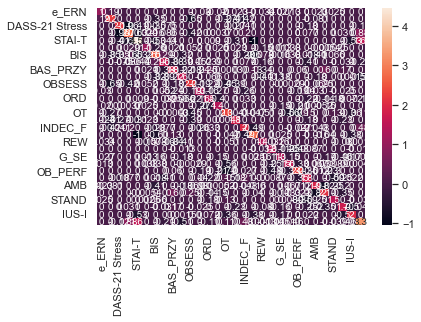

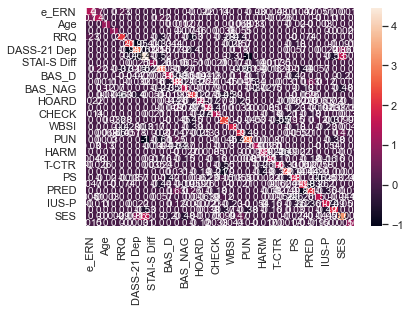

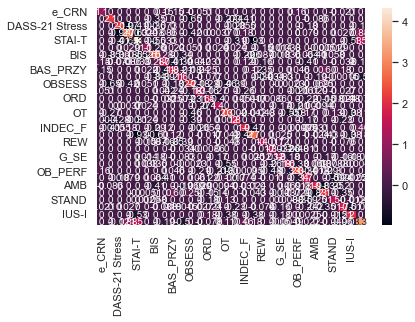

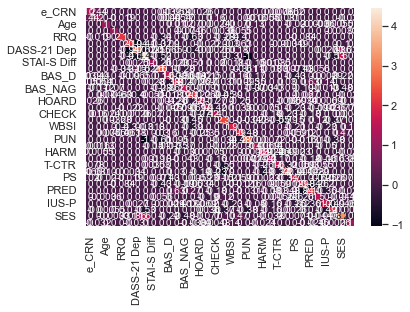

In [10]:
sns.set(rc={'figure.figsize':(30 , 30)})

for i, matrix in enumerate(precision_matrixes):
    plt.figure(i)
    sns.heatmap(
        data = matrix,
        annot=True        
    )

##### Test

In [11]:
# sns.set(rc={'figure.figsize':(30 , 30)})

# for i, matrix in enumerate(precision_matrixes_test):
#     plt.figure(i)
#     sns.heatmap(
#         data = matrix,
#         annot=True        
#     )

---
## Calculate nodes predictability

In [12]:
def calculate_nodes_predictability(X, precision_matrix_df, threshold=0.02):
    precision_matrix_df_mask = precision_matrix_df.mask(abs(precision_matrix_df) <= threshold, False)
    precision_matrix_df_mask = precision_matrix_df_mask.mask(abs(precision_matrix_df_mask) > threshold, True)
    
    np.fill_diagonal(precision_matrix_df_mask.values, False)

    explained_variance = []

    for node in precision_matrix_df_mask.columns:
        mask = precision_matrix_df_mask.loc[node].to_numpy()
        masked_colums = precision_matrix_df_mask.columns[mask]    
        y_ = X[[node]]
        # display(y)

        X_ = X[masked_colums]
        # display(X)

        lm = LinearRegression()
        lm.fit(X_, y_)

        score = lm.score(X_,y_)
        # print(f"Score for node {node}: {score}\n")
        explained_variance.append(score)


    explained_variance_df = pd.DataFrame(np.array(explained_variance).reshape(1,-1), columns=precision_matrix_df.columns)
    return explained_variance_df

Calculate nodes predictabilities for models

In [13]:
ern_precision = precision_matrixes[0]
ern_precision_cov = precision_matrixes[1]
crn_precision = precision_matrixes[2]
crn_precision_cov = precision_matrixes[3]

X_ern = results_ern_df
X_ern_cov = results_ern_lat_demo_df
X_crn = results_crn_df
X_crn_cov = results_crn_lat_demo_df

In [14]:
ern_predictability = calculate_nodes_predictability(X_ern, ern_precision)
ern_cov_predictability = calculate_nodes_predictability(X_ern_cov, ern_precision_cov)
crn_predictability = calculate_nodes_predictability(X_crn, crn_precision)
crn_cov_predictability = calculate_nodes_predictability(X_crn_cov, crn_precision_cov)

## Visualize ERN and CRN graphs

#### Extract list of links from precision matrices

In [15]:
def get_links(precision_matrix_df, threshold=0.02):
    #prepare the matrix for network illustration
    precision_matrix_df = precision_matrix_df.where(np.triu(np.ones(precision_matrix_df.shape)).astype(np.bool))

    links = precision_matrix_df.stack().reset_index()
    links.columns = ['var1', 'var2','weight']
    links=links.loc[ (abs(links['weight']) > threshold) &  (links['var1'] != links['var2']) ]
    
    # remove links between EEG features for clarity
    # links = links[~((links['var1'].str.contains("e_")) & (links['var2'].str.contains("e_")))]
    
    links = links.round(3)
    
    return links

In [16]:
test

False

In [17]:
if test:
    test_links = []

    for matrix in precision_matrixes_test:
        this_links = get_links(matrix)
        test_links.append(this_links)
else:
    links = []

    for matrix in precision_matrixes:
        this_links = get_links(matrix)
        links.append(this_links)

Leave only N leafs from parent (eeg) nodes

In [18]:
def leave_n_edges_from_eeg(links, N=2):
    parents = set(links[links['var1'].str.contains("e_ERN") | links['var1'].str.contains("e_CRN")]['var1'])

    final_edges = []
    edges_df = pd.DataFrame({})
    leafs = set()

    for parent in parents:
        this_leafs = []

        parent_edges = links[links['var1'] == parent]
        final_edges.append(parent_edges)
        leafs.update(parent_edges['var2'])


    for i in range(1,N+1):
        parents = leafs
        leafs = set()

        for parent in parents:
            parent_edges = links[(links['var1'] == parent) | (links['var2'] == parent)]

            final_edges.append(parent_edges)
            leafs.update(parent_edges['var2'])
            leafs.update(parent_edges['var1'])

    edges_df = pd.concat(final_edges, axis=0, ignore_index=True)
    edges_df = edges_df.drop_duplicates(subset = ["var1", 'var2'])
    
    return edges_df

#### Bulid the graph from the links

Node labels mappers

In [19]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_ERN': "1E",
    'e_LT_F': "4C",
    'performance': "5C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_CRN': "2E",
    'e_LT_F2_C': "4C",
    'performance': "5C",
}

In [20]:
def draw_graph(links, basic_links=None, basic=False, mapping=mapping_ern, seed=1, nodes_predictabilities=None, scale=1, specific_positions = []):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    
    palette = sns.color_palette("colorblind")
    
          
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    
    ax = fig.add_axes([0,0,1,1], aspect=1)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    
    # create graph
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G.nodes()]
    # set nodes position
    edges = G.edges() 
    
    for u,v in edges:
        G[u][v]['weight'] = abs(G[u][v]['weight'])
        # print(f"{u},{v},{G[u][v]['weight']}")
    
    pos_i = nx.spring_layout(G, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=scale, seed=seed)
    pos = pos_i
    # pos = nx.kamada_kawai_layout(G, pos=pos_i, scale=1)
    
    for position in specific_positions:
        pos[position[0]] = position[1]
    
    # drawing all links
    if basic is False:
        G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        G = nx.relabel_nodes(G, mapping)
        
        edges = G.edges() 
           
        weights = []
        for u,v in edges:
            weight = G[u][v]['weight']
            # print(f"{u},{v},{weight}")
            weights.append(weight)
            
        edge_color = [('red' if edge < 0 else 'blue') for edge in weights]

        weights_alphas = []
        weight_bold = []

        for edge_weight in weights:
            if abs(edge_weight) < 0.05:
                alpha = 0.2 
                bold = 1
            elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.1:
                alpha = 0.25
                bold = 1
            elif abs(edge_weight) >= 0.1 and abs(edge_weight) < 0.15:
                alpha = 0.3
                bold = 2
            elif abs(edge_weight) >= 0.15 and abs(edge_weight) < 0.2:
                alpha = 0.35
                bold = 1
            elif abs(edge_weight) >= 0.15 and abs(edge_weight) < 0.2:
                alpha = 0.38
                bold = 1
            elif abs(edge_weight) >= 0.2 and abs(edge_weight) < 0.25:
                alpha = 0.40
                bold = 1
            elif abs(edge_weight) >= 0.25 and abs(edge_weight) < 0.3:
                alpha = 0.42
                bold = 1
            elif abs(edge_weight) >= 0.3 and abs(edge_weight) < 0.35:
                alpha = 0.45
                bold = 1
            else:
                alpha = 0.5
                bold = 1
            weights_alphas.append(alpha)
            weight_bold.append(bold)

    # drawing EEG links 'first' || 'only'
    if (basic is not False):
        G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        G = nx.relabel_nodes(G, mapping)
        
        edges = G.edges() 
           
        weights = []
        for u,v in edges:
            weight = G[u][v]['weight']
            # print(f"{u},{v},{weight}")
            weights.append(weight)
            
        edge_color = [('red' if edge < 0 else 'blue') for edge in weights]
        
        weights_alphas = []
        weight_bold = []

        for edge_weight in weights:
            alpha = 0.15 
            bold = 1
            weights_alphas.append(alpha)
            weight_bold.append(bold)
            
        ###########################################################################################################
        G_eeg = nx.from_pandas_edgelist(basic_links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
        G_eeg = nx.relabel_nodes(G_eeg, mapping)
        
        eeg_edges = G_eeg.edges() 
        
        weights_eeg = []
        for u,v in eeg_edges:
            weight = G_eeg[u][v]['weight']
            print(f"{u},{v},{weight}")
            weights_eeg.append(weight)
            
        # edges_eeg_list = list(zip(basic_links.var1.to_list(), basic_links.var2.to_list()))
        edge_eeg_color = [('red' if edge < 0 else 'blue') for edge in weights_eeg]
        
        # weights_eeg = basic_links.weight.to_list()
        weights_eeg_alphas = []
        weights_eeg_bold = []

        for edge_weight in weights_eeg:
            if abs(edge_weight) < 0.05:
                alpha = 0.3 
                bold = 2
            elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
                alpha = 0.35
                bold = 2
            elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
                alpha = 0.40
                bold = 3
            elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
                alpha = 0.45
                bold = 3
            else:
                alpha = 0.6
                bold = 3
            weights_eeg_alphas.append(alpha)
            weights_eeg_bold.append(bold)
            
        
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 190,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    if basic == False:
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G.edges(),
            edge_color = edge_color,
            alpha=weights_alphas,
            width = weight_bold,
        )
        

    if basic_links is not None and basic == 'only':
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G_eeg.edges(),
            edge_color = edge_eeg_color,
            alpha=weights_eeg_alphas,
            width = weights_eeg_bold,
        )
    
    if basic_links is not None and basic == 'first':
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G.edges(),
            edge_color = edge_color,
            alpha=weights_alphas,
            width = weight_bold,
        )
        
        nx.draw_networkx_edges(
            G, 
            pos=pos,
            edgelist = G_eeg.edges(),
            edge_color = edge_eeg_color,
            alpha=weights_eeg_alphas,
            width = weights_eeg_bold,
        )
    
    # add nodes predictabilities
    if nodes_predictabilities is not None:
        nodes_predictabilities = nodes_predictabilities.rename(columns=mapping)

        patches = []
        colors = []
        for item in pos.items():
            node_id = item[0]
            # print(node_id)
            node_predictability = nodes_predictabilities[node_id].to_list()[0]
            node_predictability_percent = 360 * node_predictability
            # print(node_predictability_percent)
            cor_x, cor_y = item[1]

            weg_bck = Wedge((cor_x, cor_y), .060, 0, 360, width=0.03, edgecolor='black', linewidth=0.3, facecolor='white')
            patches.append(weg_bck)
            colors.append(0)
            ax.add_patch(weg_bck)

            weg = Wedge((cor_x, cor_y), .060, 0, node_predictability_percent, width=0.03, edgecolor='black', linewidth=0.3, facecolor='gray')
            patches.append(weg)
            colors.append(1)
            ax.add_patch(weg)
        

    # p = PatchCollection(patches, edgecolor='black', linewidth=0.3)
    # print(100 * np.random.rand(len(patches)))
    # p.set_array(colors)
    # ax.add_collection(p)   
        
    

    plt.show()   

##### Train links

- ERN graph

Draw graph


In [21]:
positions = [
    ('23Q', [0.85, 0.4]),
    ('1E', [0.2, -0.75])
]

1E,1Q,0.194
1E,8Q,-0.03
1E,12Q,-0.023
1E,22Q,-0.034
1E,29Q,-0.027
1E,30Q,0.023
1E,32Q,0.025


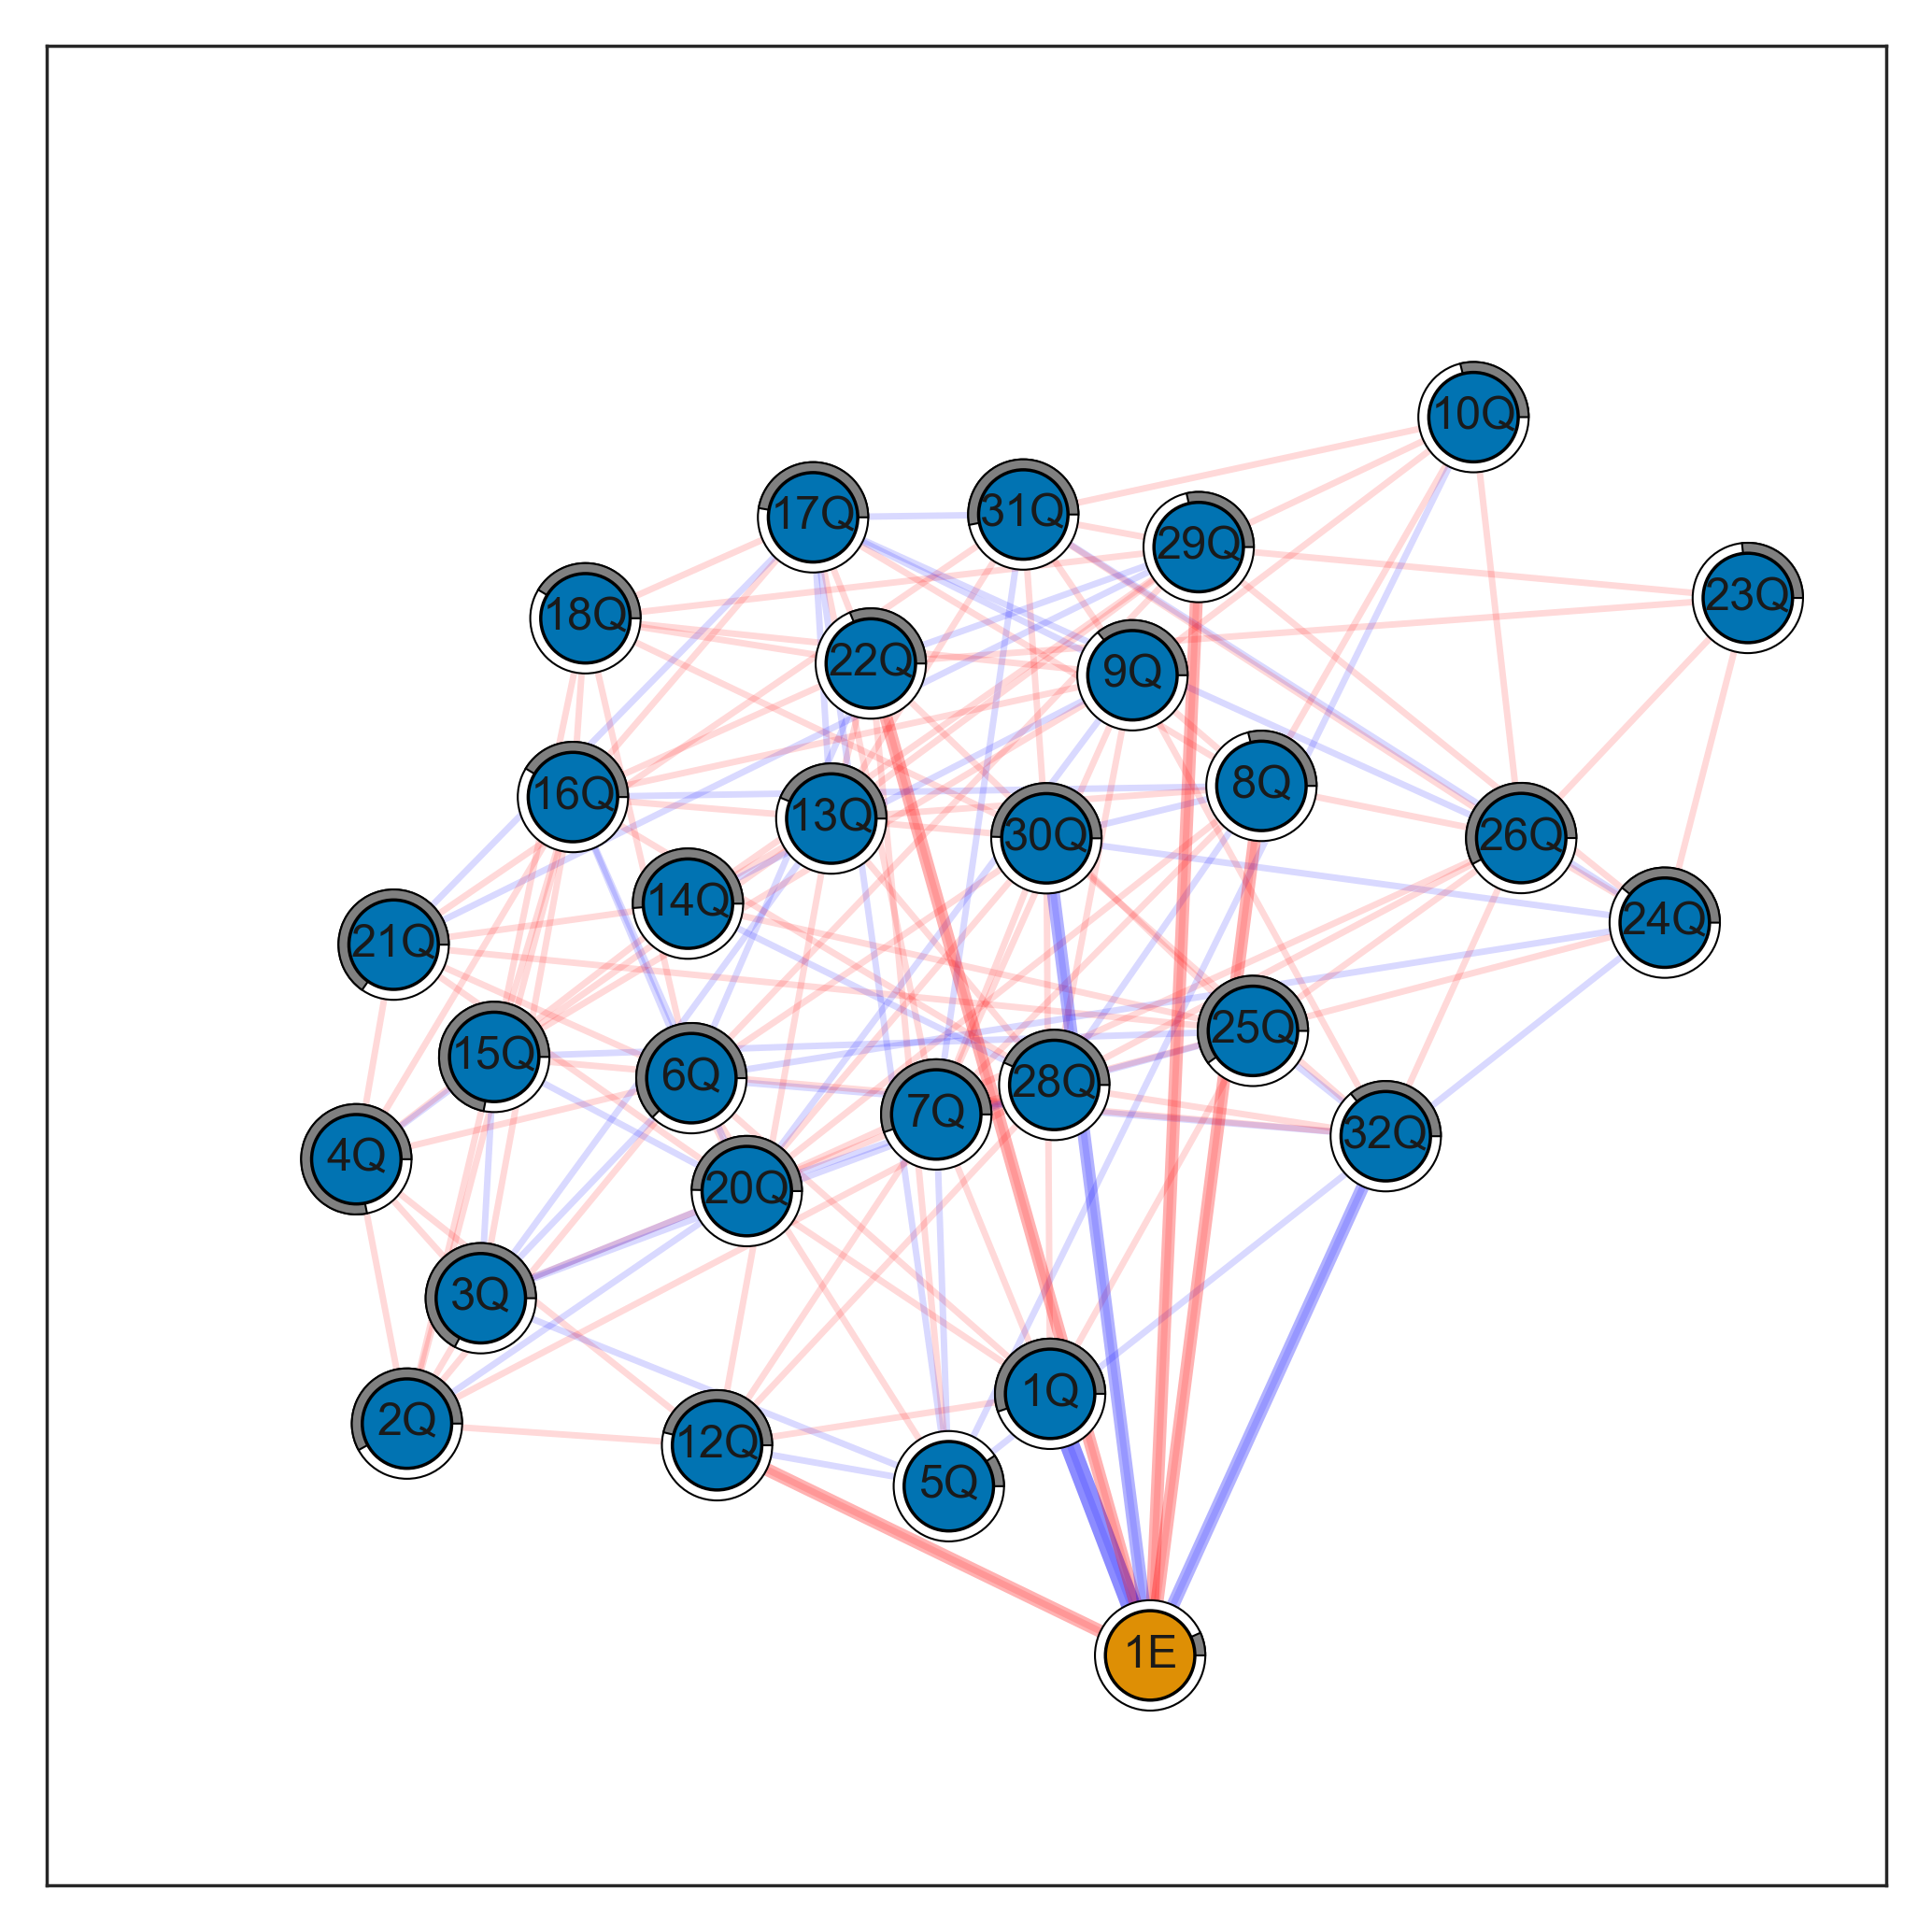

In [22]:
draw_graph(
    links[0], 
    seed=13, 
    basic_links=leave_n_edges_from_eeg(links[0], N=0),
    basic='first', 
    nodes_predictabilities = ern_predictability,
    specific_positions=positions,
) 

Display the predictability of nodes

In [23]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_predictability)

e_ERN       RRQ  DASS-21 Stress  DASS-21 Dep   STAI-T  STAI-S Diff  \
0  0.06739  0.552296        0.579643     0.671727  0.78109     0.093599   

        BIS    BAS_D  BAS_PRZY   BAS_NAG   OBSESS     HOARD       ORD  \
0  0.625591  0.41349  0.473137  0.413509  0.55208  0.288864  0.358292   

      CHECK        OT      WBSI   INDEC_F       PUN       REW     HARM  \
0  0.288755  0.598628  0.462183  0.496385  0.653142  0.311978  0.26703   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.285453  0.390865  0.577982  0.433276  0.495466  0.530123  0.359533   

      IUS-P     IUS-I       SES  
0  0.437958  0.512764  0.718992

Save graph

In [91]:
G_ = nx.from_pandas_edgelist(links[0],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/ern_graph.gml')

- ERN cov graph

Draw graph


In [25]:
positions = [
    ('3C', [0.2, -0.75])
]

1E,4C,0.697
1E,1Q,0.226
1E,8Q,-0.022
1E,22Q,-0.03
1E,30Q,0.047


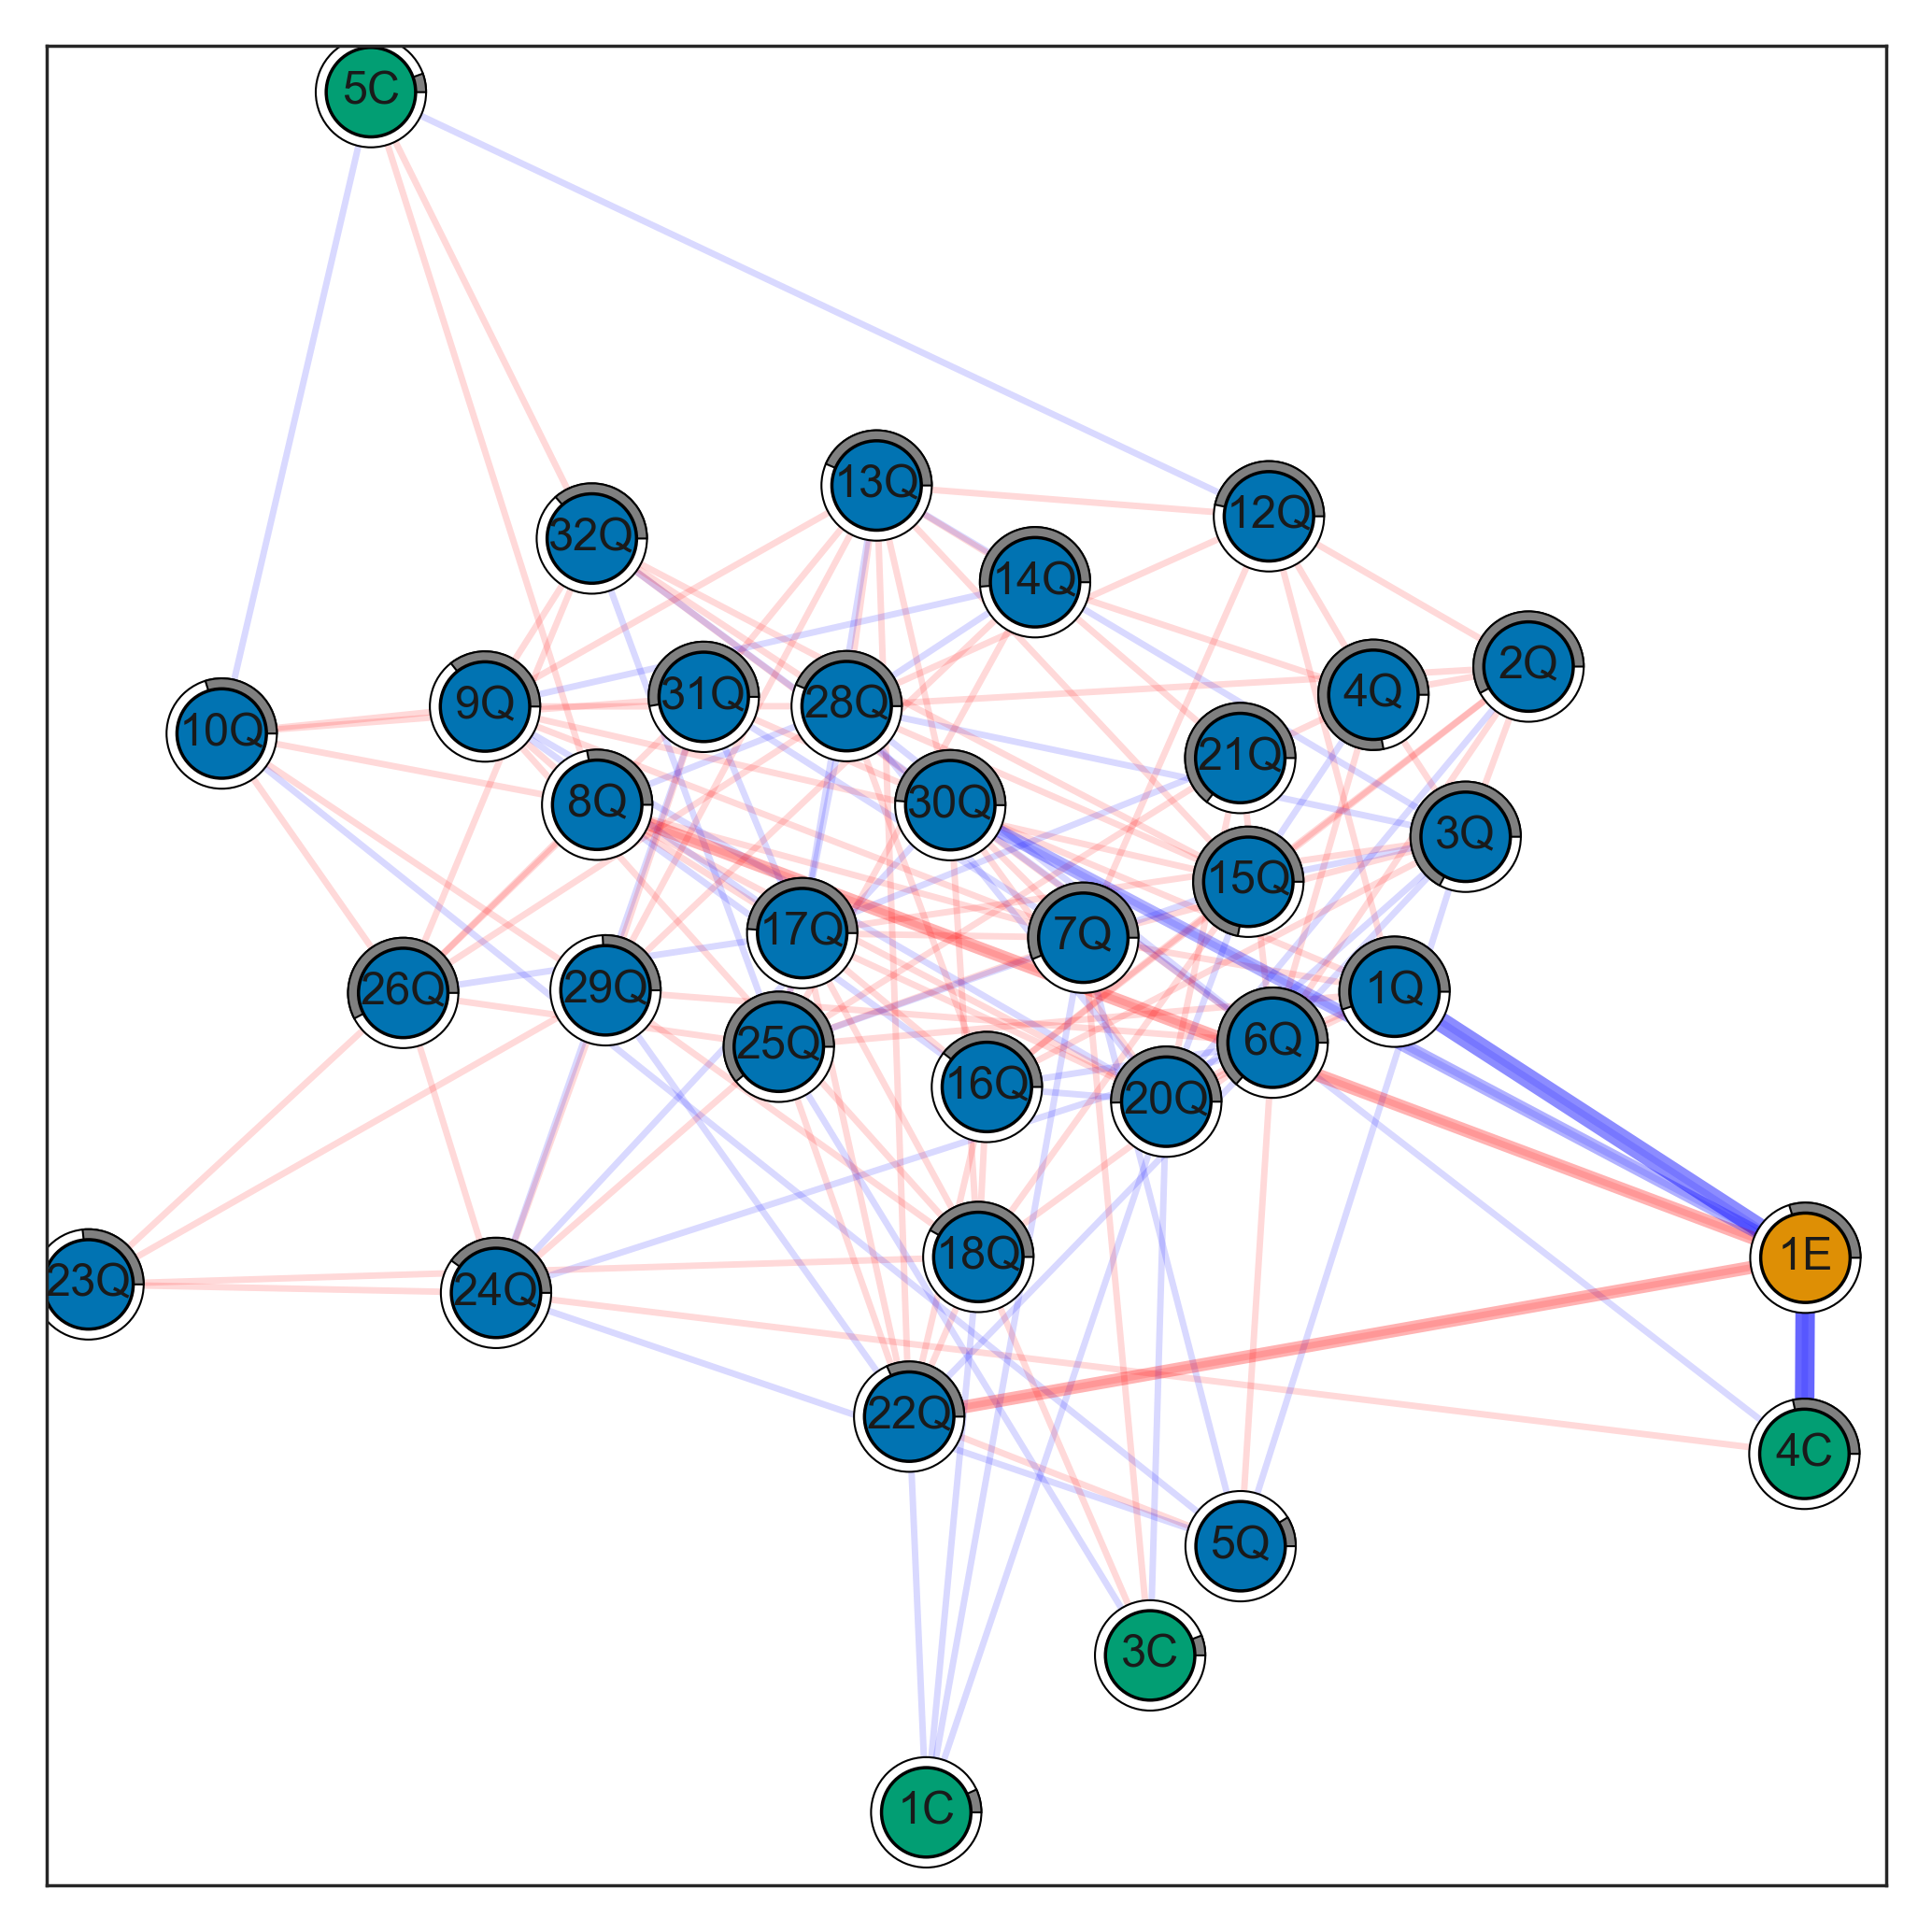

In [26]:
draw_graph(
    links[1], 
    seed=13, 
    basic_links=leave_n_edges_from_eeg(links[1], N=0),
    basic='first', 
    nodes_predictabilities = ern_cov_predictability, 
    specific_positions=positions
) 

#1E,1Q,0.194 - rum
# 1E,8Q,-0.03 - hoard
# 1E,12Q,-0.023 - - WBSI - znika
# 1E,22Q,-0.034 - reward
# 1E,29Q,-0.027 - guilt - znika
# 1E,30Q,0.023 - AMB
# 1E,32Q,0.025 - high stand znika

Display predictability of nodes

In [27]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(ern_cov_predictability)

e_ERN    e_LT_F       Age  Handness       RRQ  DASS-21 Stress  \
0  0.297613  0.283414  0.067939  0.058827  0.552296        0.579643   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS    BAS_D  BAS_PRZY   BAS_NAG  \
0     0.671764  0.779158      0.08745  0.635197  0.39476  0.488097  0.419247   

     OBSESS     HOARD       ORD    CHECK       OT      WBSI   INDEC_F  \
0  0.563633  0.279581  0.356297  0.29796  0.60826  0.465944  0.502746   

        PUN       REW      HARM      G_SE     T-CTR   OB_PERF        PS  \
0  0.646206  0.316156  0.267168  0.258326  0.400396  0.576716  0.436356   

        AMB      PRED     STAND     IUS-P     IUS-I      SES  performance  
0  0.487045  0.526643  0.364248  0.435896  0.512764  0.71932     0.054696

Save graph

In [44]:
G_ = nx.from_pandas_edgelist(links[1],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/ern_cov_graph.gml')

- CRN graph

Draw graph

In [29]:
positions = [
    # ('2E', [0.1, 0.8]),
    ('23Q', [-0.8, 0.1])
]

2E,16Q,0.153
2E,17Q,-0.148
2E,8Q,-0.051
2E,26Q,0.163
2E,13Q,-0.021


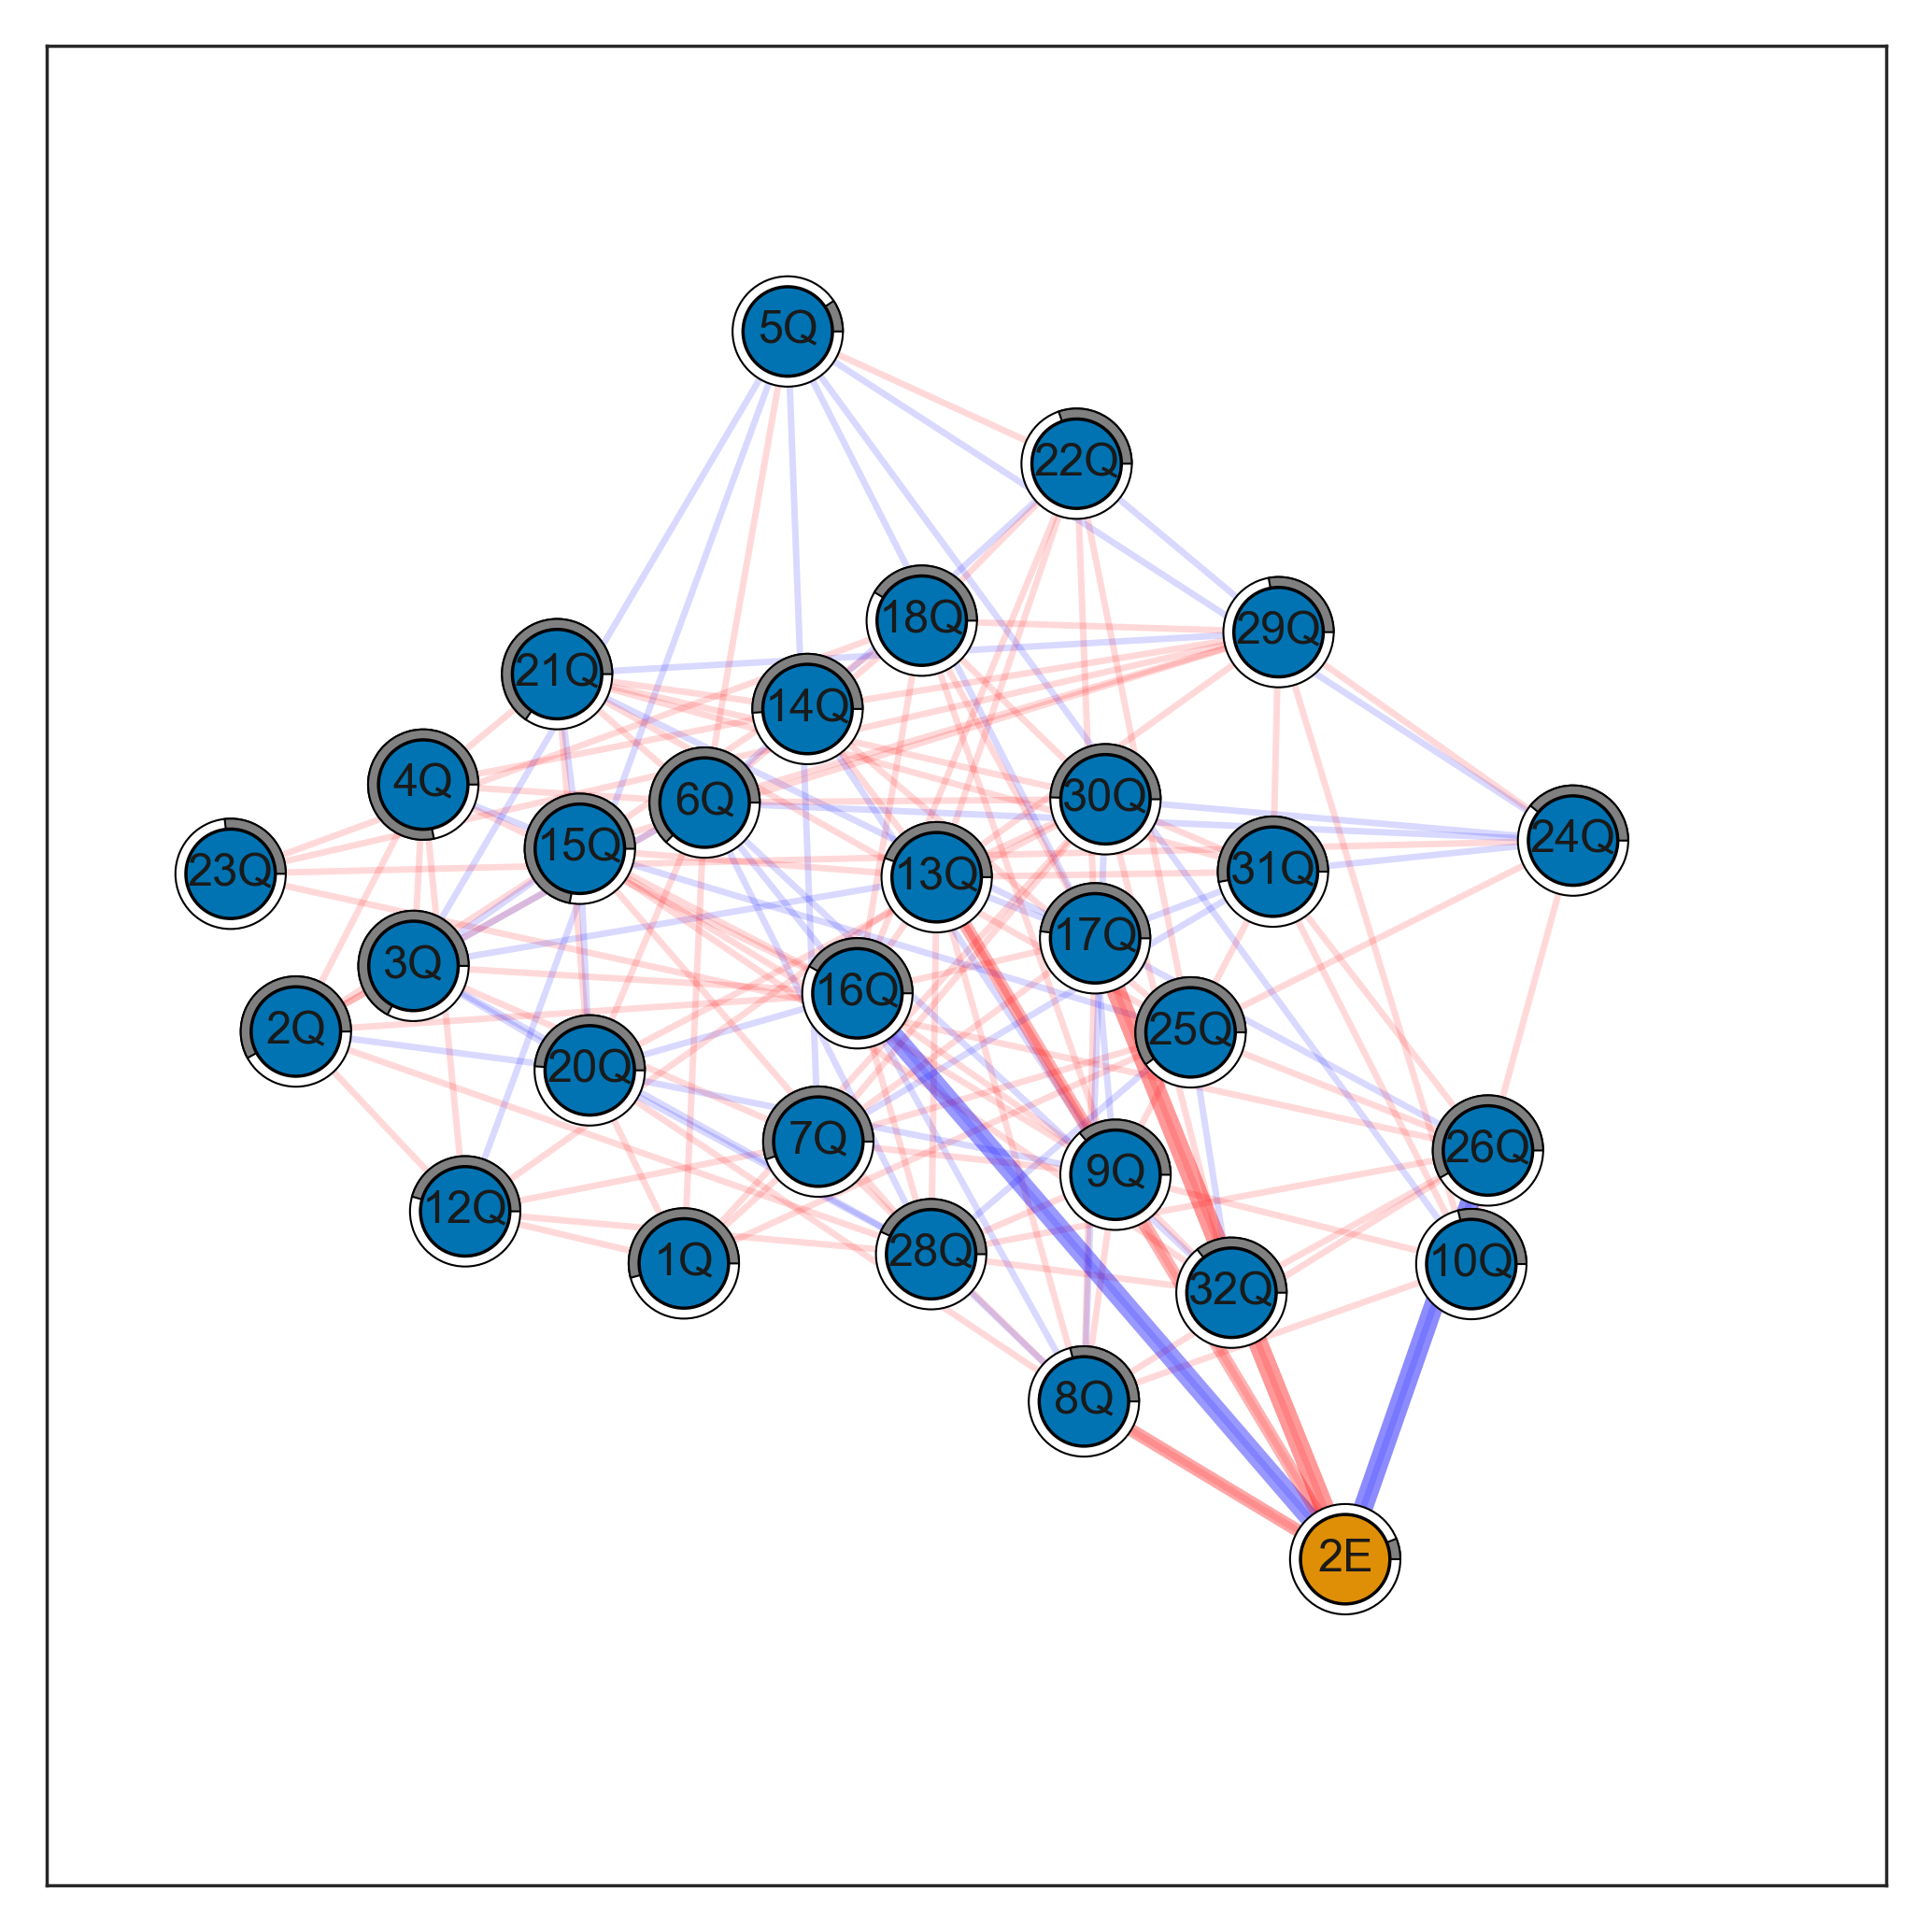

In [31]:
draw_graph(
    links[2], 
    seed=16, 
    basic_links=leave_n_edges_from_eeg(links[2], N=0), 
    basic='first', 
    mapping=mapping_crn, 
    nodes_predictabilities = crn_predictability,
    specific_positions=positions
) 

Display predictability

In [32]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(crn_predictability)

e_CRN       RRQ  DASS-21 Stress  DASS-21 Dep   STAI-T  STAI-S Diff  \
0  0.0609  0.541908        0.579643     0.671727  0.78109     0.093599   

        BIS     BAS_D  BAS_PRZY   BAS_NAG   OBSESS     HOARD     ORD  \
0  0.627077  0.418601  0.479535  0.413931  0.55208  0.290157  0.3629   

      CHECK        OT      WBSI  INDEC_F       PUN     REW      HARM  \
0  0.288755  0.598628  0.456921  0.48813  0.653581  0.3028  0.267168   

       G_SE     T-CTR   OB_PERF        PS       AMB      PRED     STAND  \
0  0.278857  0.390865  0.582525  0.433208  0.494506  0.530123  0.356786   

      IUS-P     IUS-I       SES  
0  0.443591  0.511032  0.720408

Save graph

In [99]:
G_ = nx.from_pandas_edgelist(links[2],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/crn_graph.gml')

- CRN cov graph

Draw graph

In [100]:
# positions = [
#     ('5C', [-0.05, 0.9]),
#     ('2C', [0.2, 0.1])
# ]

2E,4C,0.436
2E,16Q,0.039
2E,17Q,-0.053
2E,8Q,-0.026
2E,26Q,0.066
2E,28Q,0.02


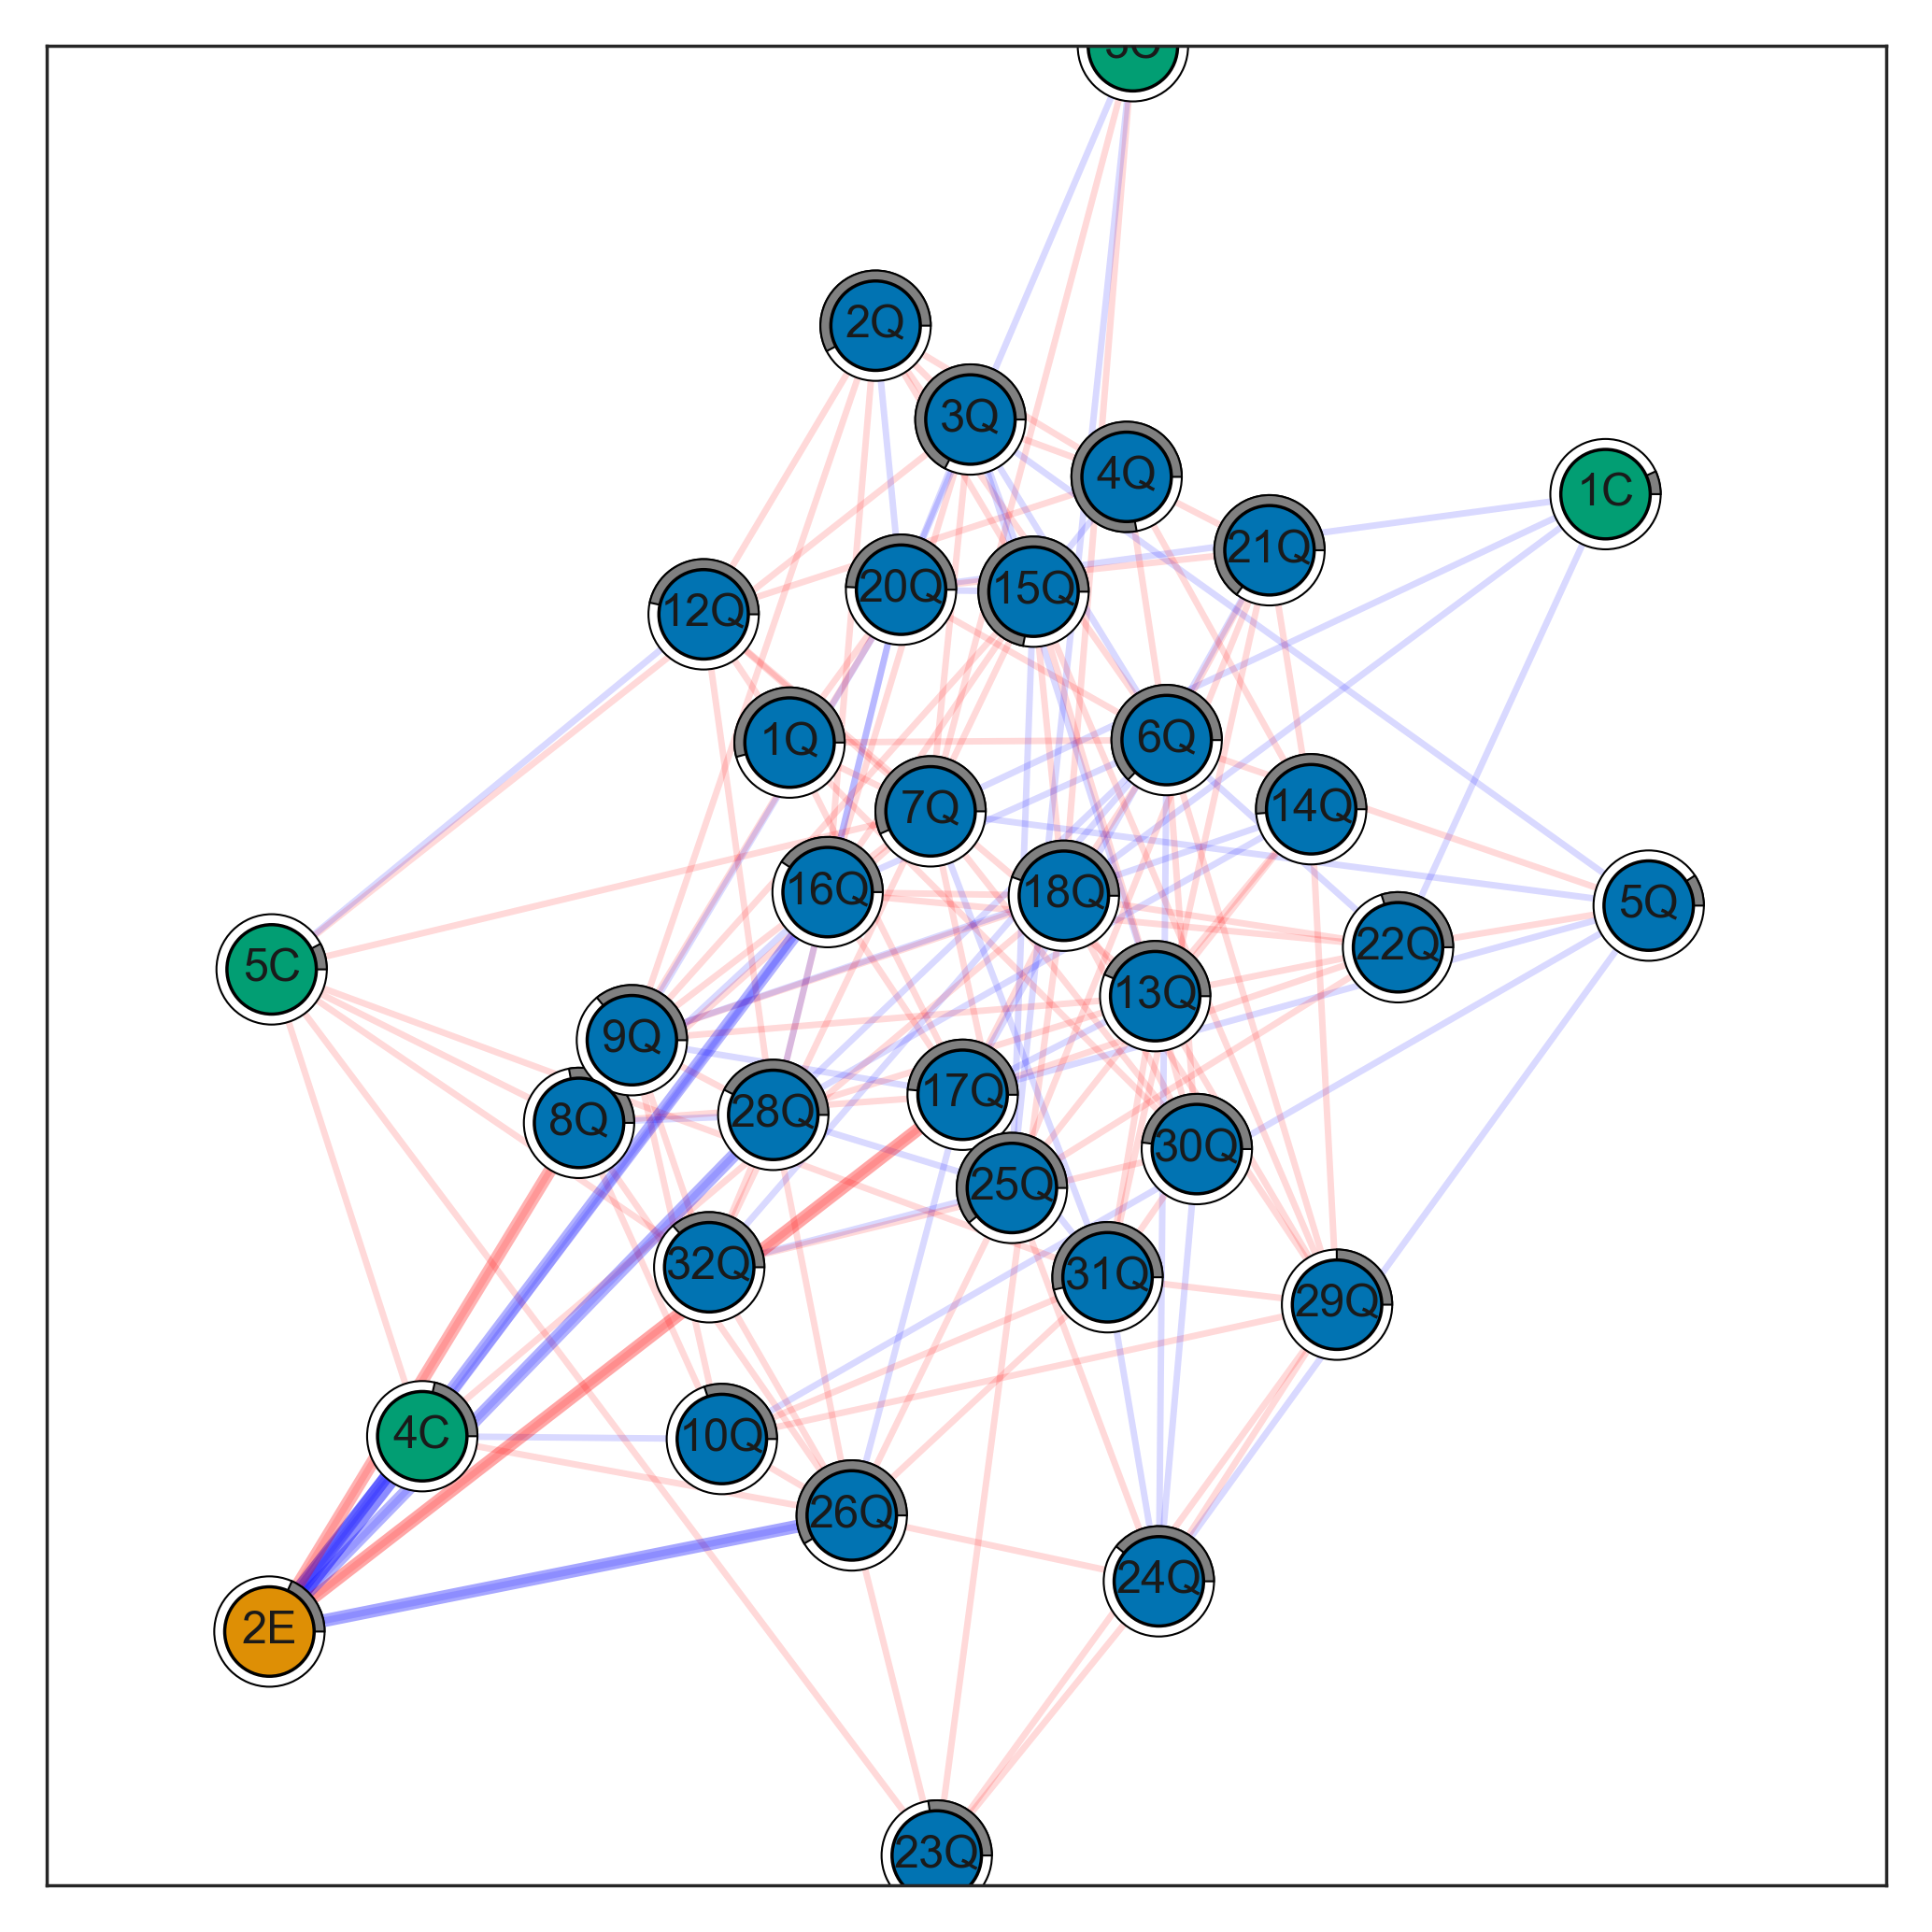

In [33]:
draw_graph(
    links[3], 
    seed=13, 
    basic_links=leave_n_edges_from_eeg(links[3], N=0), 
    basic='first', 
    mapping=mapping_crn,
    nodes_predictabilities = crn_cov_predictability,
    # specific_positions = positions
) 

Display predictability of nodes

In [34]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(crn_cov_predictability)

e_CRN  e_LT_F2_C       Age  Handness       RRQ  DASS-21 Stress  \
0  0.183273   0.213325  0.067939  0.058827  0.541908        0.576316   

   DASS-21 Dep    STAI-T  STAI-S Diff       BIS     BAS_D  BAS_PRZY   BAS_NAG  \
0     0.673284  0.779158     0.091887  0.627077  0.407234  0.484897  0.444706   

     OBSESS     HOARD       ORD     CHECK       OT      WBSI   INDEC_F  \
0  0.566578  0.279413  0.359532  0.301502  0.60826  0.465944  0.492019   

        PUN       REW     HARM      G_SE     T-CTR   OB_PERF       PS  \
0  0.648324  0.298648  0.27473  0.250893  0.390865  0.585095  0.42457   

        AMB      PRED     STAND     IUS-P     IUS-I       SES  performance  
0  0.481019  0.536242  0.364248  0.435896  0.512764  0.719585     0.076855

Save graph

In [45]:
G_ = nx.from_pandas_edgelist(links[3],'var1','var2', edge_attr='weight', create_using=nx.Graph())
nx.write_gml(G_, '../data/graphs/crn_cov_graph.gml')

##### Test links

In [49]:
sns.set(rc={'figure.figsize':(30 , 30)})

if test:   
    for i, this_links in enumerate(links_test):
        plt.figure(i)
        draw_graph(leave_n_edges_from_eeg(this_links, N=0))

## Visualize ERN and CRN graphs difference

### 1. Continuous difference: based on precision matrixes

Define precision matrices

In [35]:
ern_precision = precision_matrixes[0]
ern_cov_precision = precision_matrixes[1]
crn_precision = precision_matrixes[2]
crn_cov_precision = precision_matrixes[3]

precision_matrices = [ern_precision, ern_cov_precision, crn_precision, crn_cov_precision]

Define node labels mappers

In [36]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_ERN': "1E",
    'e_LT_F': "4C",
    'performance': "5C",
}

mapping_crn = {
   "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_CRN': "1E",
    'e_LT_F2_C': "4C",
    'performance': "5C",
}

Create links from precision matrices

- Here, the threshold is set very low so as not to introduce an artificial qualitative difference between ERN and CRN networks when the link is slightly below the threshold in one network (and will be zeroed) and slightly above in the second (and will not be zeroed).

In [37]:
links_for_diffs = []

for matrix_ in precision_matrices: 
    this_link = leave_n_edges_from_eeg(get_links(matrix_, threshold=0.005), N=0)
    # this_link = get_links(matix, threshold=0.005)
    links_for_diffs.append(this_link)

Create graphs from provided links

In [38]:
def create_g(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [39]:
ern_graph = create_g(links_for_diffs[0], mapping_ern)
ern_cov_graph = create_g(links_for_diffs[1], mapping_ern)
crn_graph = create_g(links_for_diffs[2], mapping_crn)
crn_cov_graph = create_g(links_for_diffs[3], mapping_crn)

Return difference between two graphs

- In addition to the graph difference, the coloring and linestyle of the links are also returned, which together inform about the exact difference between the two networks.

- The threshold is set for the maximum difference between the link in two nets, which will be considered as no difference (this indicates no change between nets).

In [40]:
# edges that was exaxtly the same are purple colored
def get_diff_graph(ern_graph, crn_graph, threshold=0.035):
    colors = []
    linestyle = []
    remove = []

    diff_graph = ern_graph.copy()
    ern_edges = ern_graph.edges()


    for u,v in ern_edges:
        # print(f"{u},{v},{ern_graph[u][v]['weight']}")
        if (v not in crn_graph[u].keys()): # link did not exist in CRN (so there is no change)
            # colors.append('green')
            # print("no change")
            if abs(ern_graph[u][v]['weight']) <= 0.02: # zero links that does not exceed link threshold 
                print(f"{u},{v},{ern_graph[u][v]['weight']} unique ERN but too low")
                diff_graph.remove_edge(u, v)
            else:
                this_color = 'red' if ern_graph[u][v]['weight'] < 0 else 'blue'
                colors.append(this_color)
                linestyle.append('solid')

        elif (ern_graph[u][v]['weight'] < 0) & (crn_graph[u][v]['weight'] < 0):
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']

            if abs(diff) <= threshold:
                colors.append('purple')
                linestyle.append('solid')
                # print("purple")
            else:
                diff_graph[u][v]['weight'] = diff
                colors.append('red')
                this_linestyle = 'dashed' if diff < 0 else ':'
                linestyle.append(this_linestyle)
                print(f"{u},{v},{ern_graph[u][v]['weight']} enlarged/dropped red")
                # print("red")

        elif (ern_graph[u][v]['weight'] > 0) & (crn_graph[u][v]['weight'] > 0):
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']

            if abs(diff) <= threshold:
                colors.append('purple')
                linestyle.append('solid')
                # print("purple")

            else:
                diff_graph[u][v]['weight'] = diff
                colors.append('blue')
                this_linestyle = ':' if diff < 0 else 'dashed'
                linestyle.append(this_linestyle)
                print(f"{u},{v},{ern_graph[u][v]['weight']} enlarged/dropped blue")
                # print('blue')

        elif (ern_graph[u][v]['weight'] > 0) & (crn_graph[u][v]['weight'] < 0):
            colors.append('blue')
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']
            diff_graph[u][v]['weight'] = diff
            this_linestyle = ':' # link change the sign; the color indicate ERN sign
            linestyle.append(this_linestyle)
            # print("blue change")


        elif (ern_graph[u][v]['weight'] < 0) & (crn_graph[u][v]['weight'] > 0):
            colors.append('red')
            diff = ern_graph[u][v]['weight'] - crn_graph[u][v]['weight']
            diff_graph[u][v]['weight'] = diff
            this_linestyle = ':' # link change the sign; the color indicate ERN sign
            linestyle.append(this_linestyle)
            # print("red change")
        else:
            print("##################### ZLE")
            
        
    return diff_graph, colors, linestyle

In [41]:
def draw_graph_diff_full(G, colors, linestyle='solid', no_purple = False, seed=1, scale=1, k=1):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    palette = sns.color_palette("colorblind")
    
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    axes = fig.add_axes([0,0,1,1], aspect=1)
    axes.set_xlim([-1,1])
    axes.set_ylim([-1,1])
    
    colors_ = colors
    linestyle_ = linestyle
    
    G_copy = G.copy()
    edges = G_copy.edges()
        
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
    
     # set position
    pos_i = nx.spring_layout(G_copy, k=k, iterations=1000, scale=scale, seed=seed)
    pos=pos_i

    # pos = nx.kamada_kawai_layout(G_copy,  pos = pos_i, scale=scale)
    
    ####################################################################################33
    
    if no_purple:
        edges = G.edges()
        for index, edge in enumerate(edges):
            if colors[index] == 'purple':
                G.remove_edge(edge[0], edge[1])
        G.remove_nodes_from(list(nx.isolates(G)))
        
        purple_indexes = [i for i, e in enumerate(colors) if e == 'purple']
        colors_ = [i for j, i in enumerate(colors) if j not in purple_indexes]
        linestyle_ = [i for j, i in enumerate(linestyle) if j not in purple_indexes]
                
    # G_copy = G.copy()
    # edges = G_copy.edges()
        
#     for u,v in edges:
#         G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
        
#     # set nodes colors
#     node_color=[palette[0] if node.find('Q') != -1 
#                 else palette[1]if node.find('E') != -1 
#                 else palette[2] for node in G_copy.nodes()]
        
    
    # set position
    # pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=1, seed=seed)
    # pos = nx.kamada_kawai_layout(G_copy, pos=pos_i, scale=1)
    
    G_copy = G.copy()
    edges = G_copy.edges()
        
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
    
     # set position
    pos_i = nx.spring_layout(G_copy, k=k, iterations=1000, scale=scale, seed=seed)
    pos=pos_i
    
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G.nodes()]
            
    edges = G.edges()
    
    
    weights = []
    for u,v in edges:
        weight = G[u][v]['weight']
        # print(f"{u},{v},{weight}")
        # print(f"{u},{v},{weight}")

        weights.append(weight)

    edge_color = colors_

    weights_alphas = []
    weight_bold = []

    for index, edge_weight in enumerate(weights):
        if colors_[index] == 'purple':
            alpha = 0.25
            bold = 1.2
        # elif abs(edge_weight) == 0:
        #     alpha = 0
        #     bold = 0
        elif abs(edge_weight) < 0.05:
            alpha = 0.4 
            bold = 2
        elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
            alpha = 0.45
            bold = 2
        elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
            alpha = 0.5
            bold = 3
        elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
            alpha = 0.45
            bold = 3
        else:
            alpha = 0.6
            bold = 3
        weights_alphas.append(alpha)
        weight_bold.append(bold)
    
    
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 200,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = G.edges(),
        edge_color = edge_color,
        style = linestyle_,
        alpha=weights_alphas,
        width = weight_bold,
    )
    
    
    plt.show()   

##### Draw the graphs

ern_graph- ERN - CRN model

1E,8Q,-0.03 enlarged/dropped red
1E,10Q,-0.02 unique ERN but too low
1E,24Q,0.013 unique ERN but too low


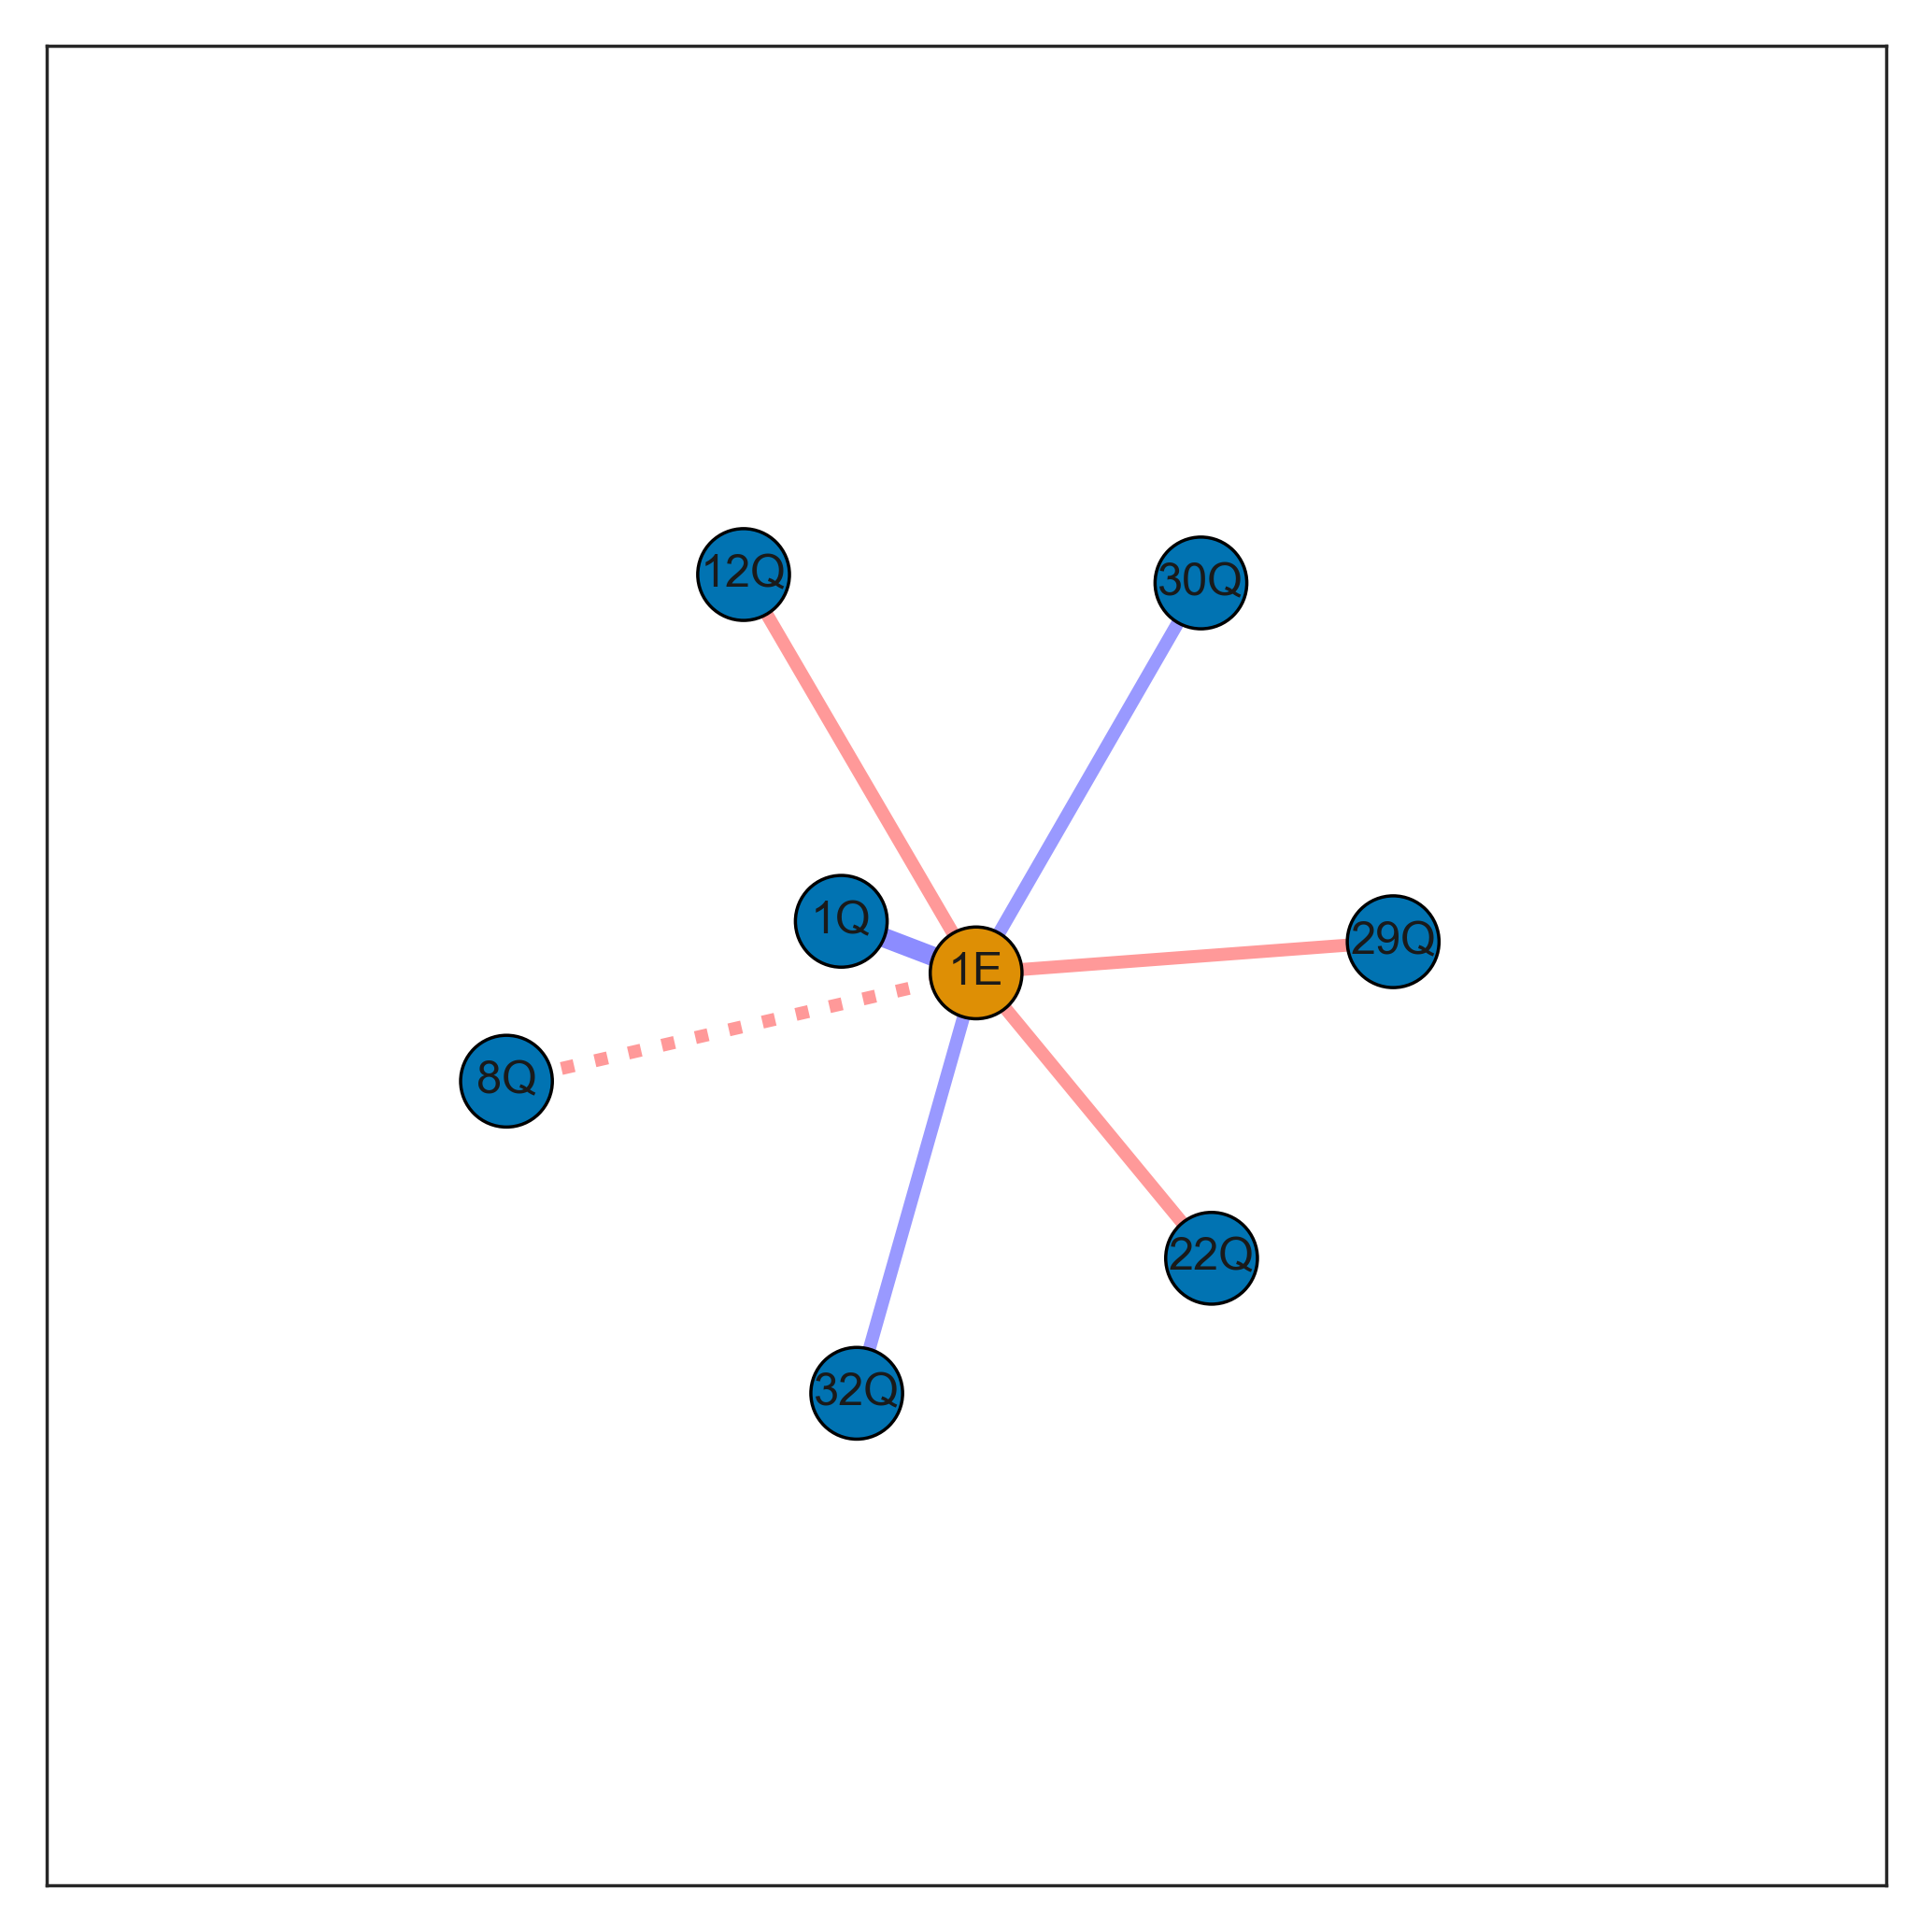

In [42]:
diff_ern, colors, styles = get_diff_graph(ern_graph, crn_graph,threshold=0.005)

draw_graph_diff_full(
    diff_ern, 
    colors=colors, 
    linestyle=styles, 
    seed=0, 
    no_purple=True, 
    scale=0.5
)

- ERN + cov - CRN model

1E,4C,0.697 enlarged/dropped blue
1E,10Q,-0.014 unique ERN but too low
1E,32Q,0.005 unique ERN but too low
1E,5C,0.015 unique ERN but too low


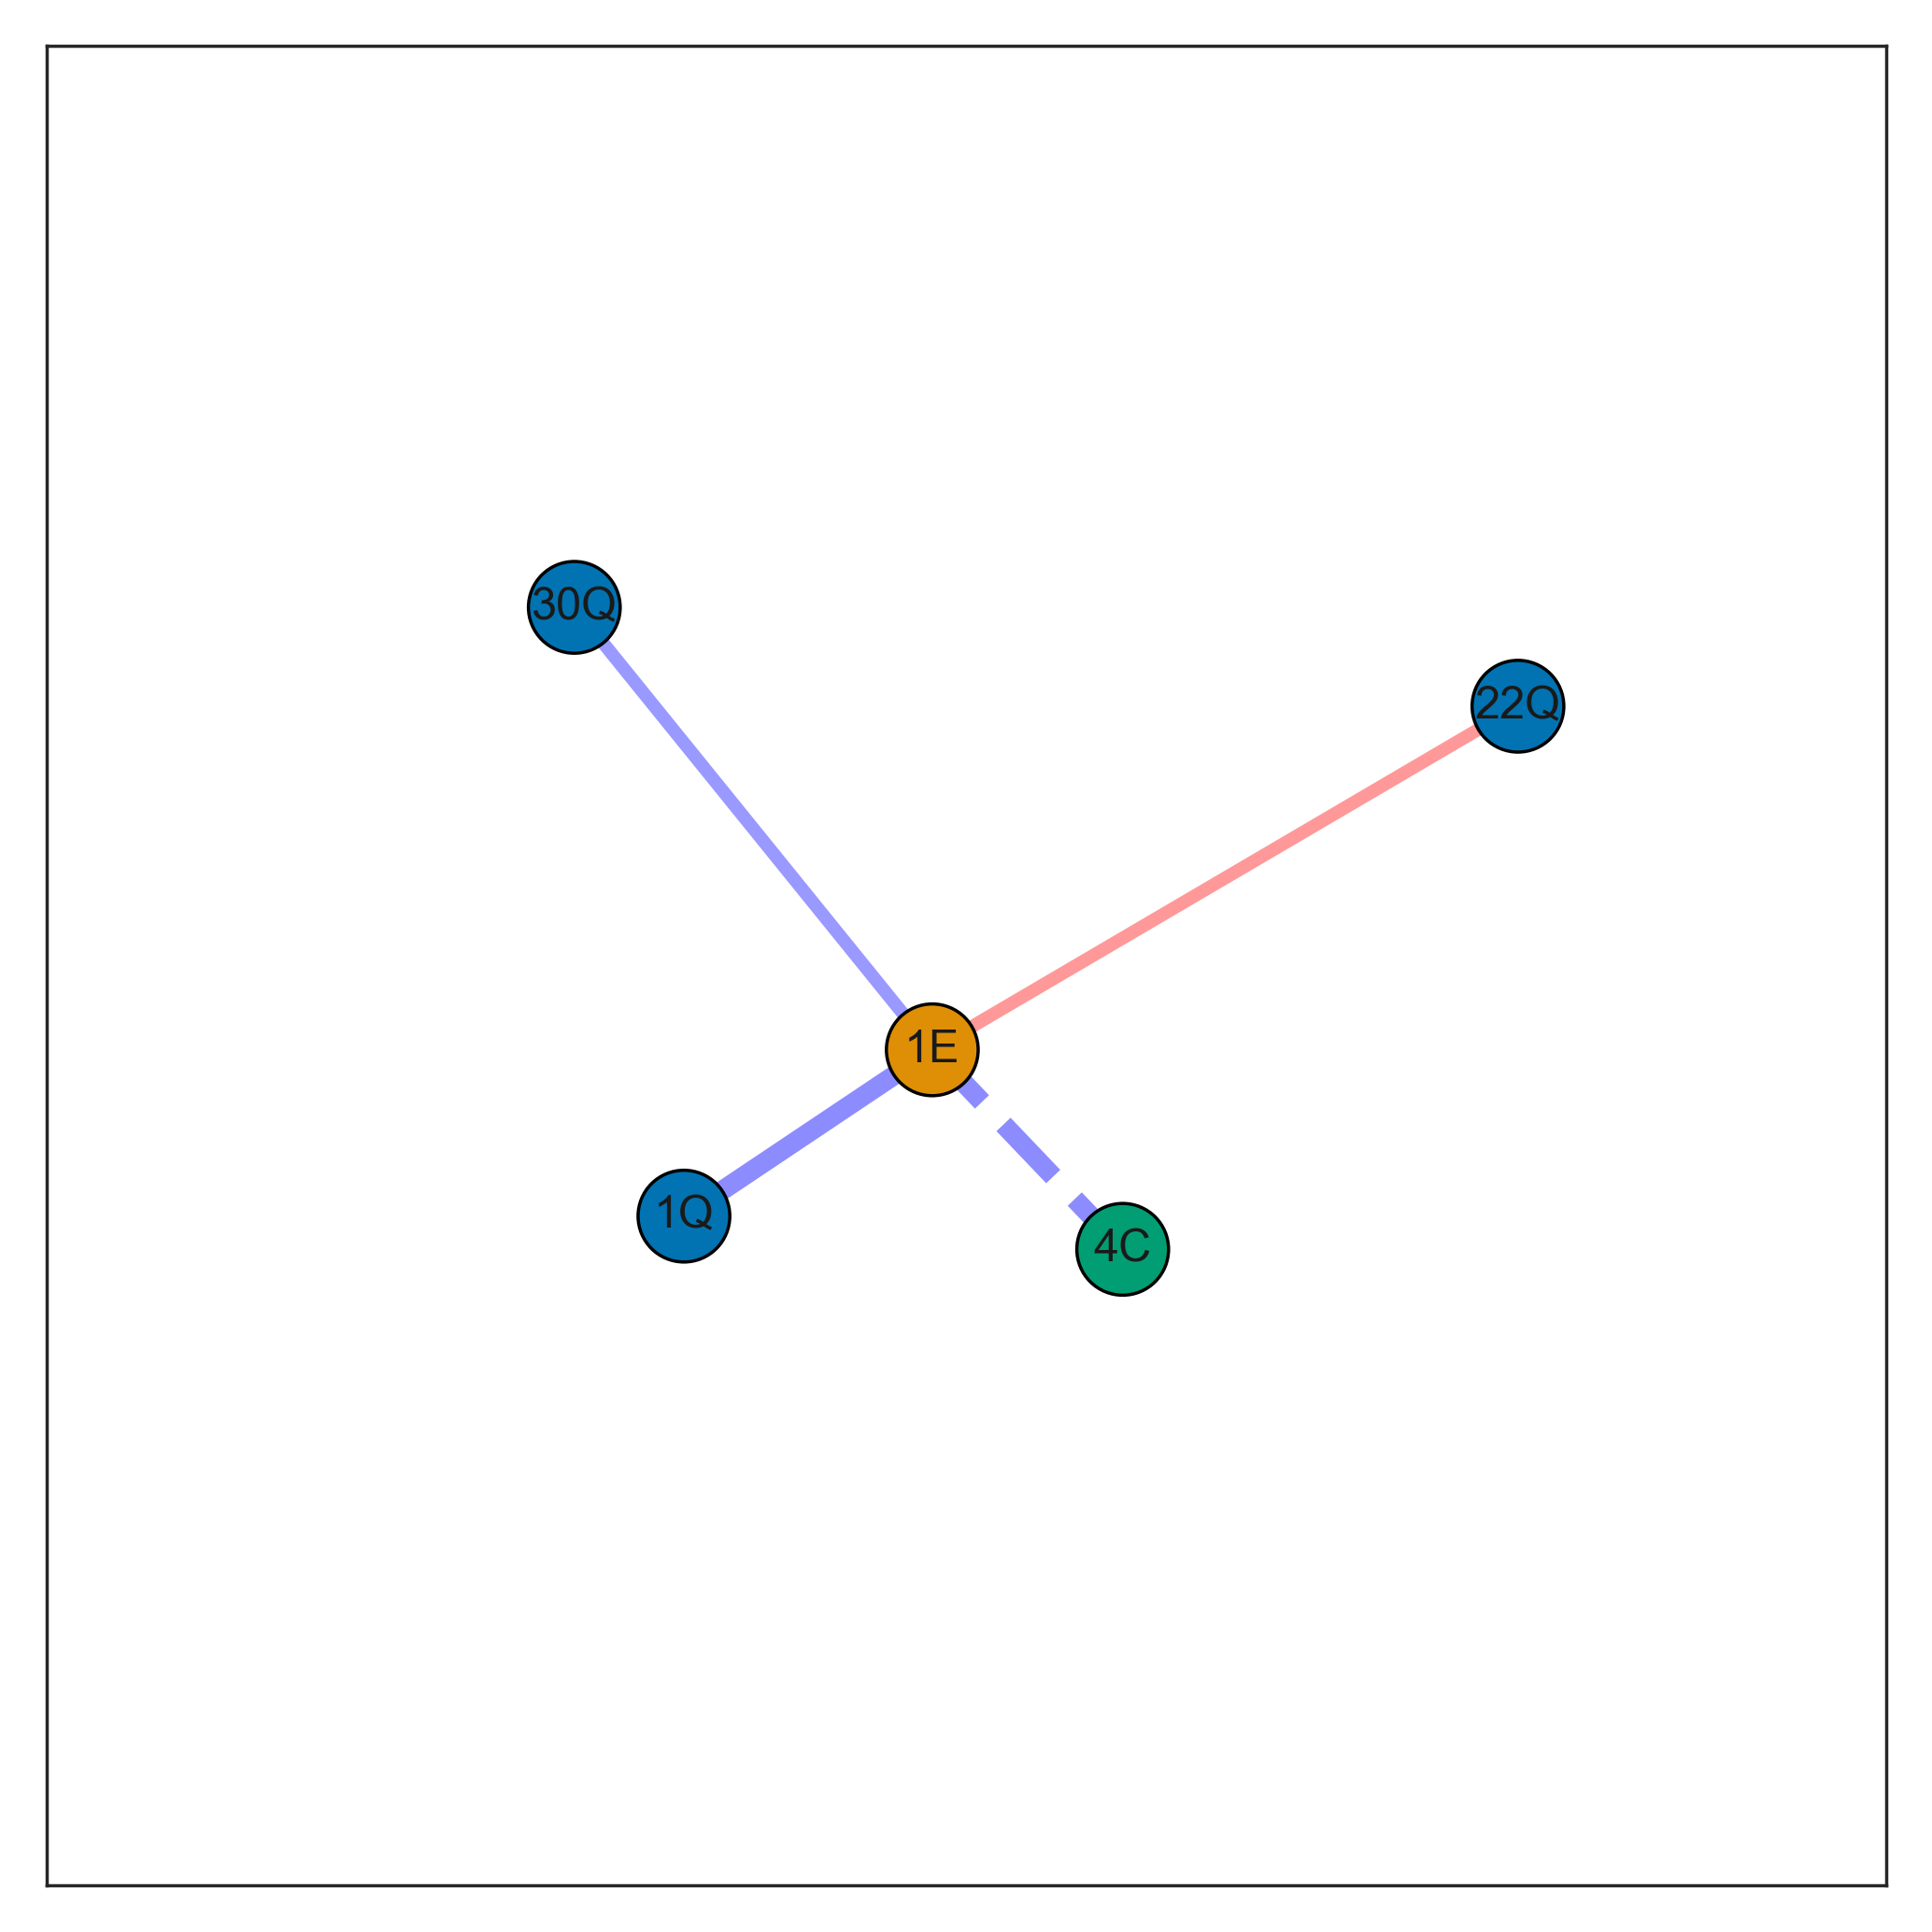

In [43]:
diff_ern, colors, styles = get_diff_graph(ern_cov_graph, crn_cov_graph,threshold=0.005 ) # 4647, 3, 6, 9
draw_graph_diff_full(diff_ern, colors=colors, linestyle=styles, seed=9, no_purple=True, scale = 0.6, k=0.15) # te siec do programu graficznego

### 2. Based on links: ERN \ (ERN & CRN)

Draw only links that exists in ERN net and do not exist in CRN net

Extract links from precision matrices

In [46]:
if test:
    test_links = []

    for matrix_ in precision_matrixes_test:
        this_links = leave_n_edges_from_eeg(get_links(matrix_, threshold=0.02), N=1)
        test_links.append(this_links)
else:
    links = []

    for matrix_ in precision_matrixes:
        this_links = leave_n_edges_from_eeg(get_links(matrix_, threshold=0.02), N=1)
        links.append(this_links)

Nodes labels mappers

In [47]:
mapping_ern = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_ERN': "1E",
    'e_LT_F': "4C",
    'performance': "5C",
}

mapping_crn = {
    "RRQ": "1Q",
    "DASS-21 Stress": "2Q",
    "DASS-21 Dep": "3Q",
    "STAI-T": "4Q",
    "STAI-S Diff": '5Q',
    "BIS": "6Q",
    "OBSESS": "7Q",
    "HOARD": "8Q",
    "ORD": "9Q",
    "CHECK": "10Q",
    "OCI-R": "11Q",
    "WBSI": "12Q",
    "IUS-P": "13Q",
    "IUS-I": "14Q",
    "SES": "15Q",
    'BAS_D': "16Q",
    'BAS_PRZY': "17Q",
    'BAS_NAG': "18Q",
    'NONFOR': "19Q",
    'INDEC_F': "20Q",
    'PUN': "21Q",
    'REW': "22Q",
    'HARM': "23Q",
    'T-CTR': "24Q",
    "OT": "25Q",
    'OB_PERF': "26Q",
    'CMDA': "27Q",
    'PS': "28Q",
    'G_SE': "29Q",
    'AMB': "30Q",
    'PRED': "31Q",
    'STAND': "32Q",   
    "Age": "1C",
    "Sex": "2C",
    "Handness": "3C",
    'e_CRN': "1E",
    'e_LT_F2_C': "4C",
    'performance': "5C",
}

Ctreate graphs from provided links

In [48]:
def create_g(links, mapping):
    G = nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())
    G = nx.relabel_nodes(G, mapping)
    return G

In [49]:
ern_graph = create_g(links[0], mapping_ern)
ern_cov_graph = create_g(links[1], mapping_ern)
crn_graph = create_g(links[2], mapping_crn)
crn_cov_graph = create_g(links[3], mapping_crn)

In [50]:
ern_graph.nodes()

NodeView(('1E', '1Q', '8Q', '12Q', '22Q', '29Q', '30Q', '32Q', '6Q', '9Q', '25Q', '26Q', '28Q', '15Q', '5Q', '16Q', '17Q', '18Q', '23Q', '13Q', '2Q', '4Q', '7Q', '20Q', '24Q', '31Q', '10Q', '21Q', '14Q'))

Calculate two graphs difference

- ERN - CRN

In [51]:
diff_graph = ern_graph.copy()

for edge in diff_graph.edges():
    if edge in crn_graph.edges():
        diff_graph.remove_edge(edge[0], edge[1])
diff_graph.remove_nodes_from(list(nx.isolates(diff_graph)))

- ERN + cov - CRN + cov

In [52]:
diff_graph_cov = ern_cov_graph.copy()

for edge in diff_graph_cov.edges():
    if edge in crn_cov_graph.edges():
        diff_graph_cov.remove_edge(edge[0], edge[1])
diff_graph_cov.remove_nodes_from(list(nx.isolates(diff_graph_cov)))

##### Draw the graphs

In [53]:
def draw_graph_diff(G, seed=1, pos=None):
    
    cm = 1/2.54
    dpi = 500

    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['axes.labelsize'] = 9
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    sns.set_style("white")
    palette = sns.color_palette("colorblind")
            
    G_copy = G.copy()
    edges = G_copy.edges()
    
    for u,v in edges:
        G_copy[u][v]['weight'] = abs(G_copy[u][v]['weight'])
        
    # set nodes colors
    node_color=[palette[0] if node.find('Q') != -1 
                else palette[1]if node.find('E') != -1 
                else palette[2] for node in G_copy.nodes()]
        
    
    # set position
    if pos == None:
        pos_i = nx.spring_layout(G_copy, k=0.1*(1/np.sqrt(len(G.nodes()))), iterations=1000, scale=1, seed=seed)
        pos=pos_i
        # pos = nx.kamada_kawai_layout(G_copy, pos=pos_i, scale=1)
    else:
        pos = pos
    
    edges = G.edges()
    # print(edges)
           
    weights = []
    for u,v in edges:
        weight = G[u][v]['weight']
        # print(f"{u},{v},{weight}")
        weights.append(weight)

    edge_color = [('red' if edge < 0 else 'blue') for edge in weights]

    weights_alphas = []
    weight_bold = []
    
    for edge_weight in weights:
        if abs(edge_weight) < 0.05:
            alpha = 0.3 
            bold = 2
        elif abs(edge_weight) >= 0.05 and abs(edge_weight) < 0.09:
            alpha = 0.35
            bold = 2
        elif abs(edge_weight) >= 0.09 and abs(edge_weight) < 0.16:
            alpha = 0.40
            bold = 3
        elif abs(edge_weight) >= 0.16 and abs(edge_weight) < 0.5:
            alpha = 0.45
            bold = 3
        else:
            alpha = 0.6
            bold = 3
        weights_alphas.append(alpha)
        weight_bold.append(bold)
        

        
    fig = plt.figure(3, figsize=(10*cm, 10*cm))
    axes = fig.add_axes([0,0,1,1], aspect=1)
    n = 1
    axes.set_xlim([-n,n])
    axes.set_ylim([-0.8,1.2])
    
    
    nx.draw_networkx_nodes(
        G, 
        pos=pos,
        linewidths=0.5,
        edgecolors='black',
        node_size = 200,
        node_color=node_color,
    )

    nx.draw_networkx_labels(
        G, 
        pos=pos,
        font_size=7,
    )
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edgelist = G.edges(),
        edge_color = edge_color,
        alpha=weights_alphas,
        width = weight_bold,
    )
    
    plt.show()   

Positions (manifold)

In [54]:
from sklearn import manifold

def manifold_position(df, node_list, mapper):
    node_position_model = manifold.LocallyLinearEmbedding(
        n_components=2, eigen_solver="dense", n_neighbors=4
    )
    
    df_ = df.rename(columns = mapper)
    
    df_ = df_[node_list]
    
    X = df_.to_numpy()
    X -= X.mean(axis=0) # data is centered in the model (assume_centered=False)
    X /= X.std(axis=0)

    embedding = node_position_model.fit_transform(X.T).T
    
    pos = dict()
    for index, node in enumerate(node_list):
        pos[node] = [embedding[0][index], embedding[1][index]]
    
    return pos

In [55]:
node_list = list(diff_graph.nodes())
pos = manifold_position(results_ern_df, node_list, mapping_ern)

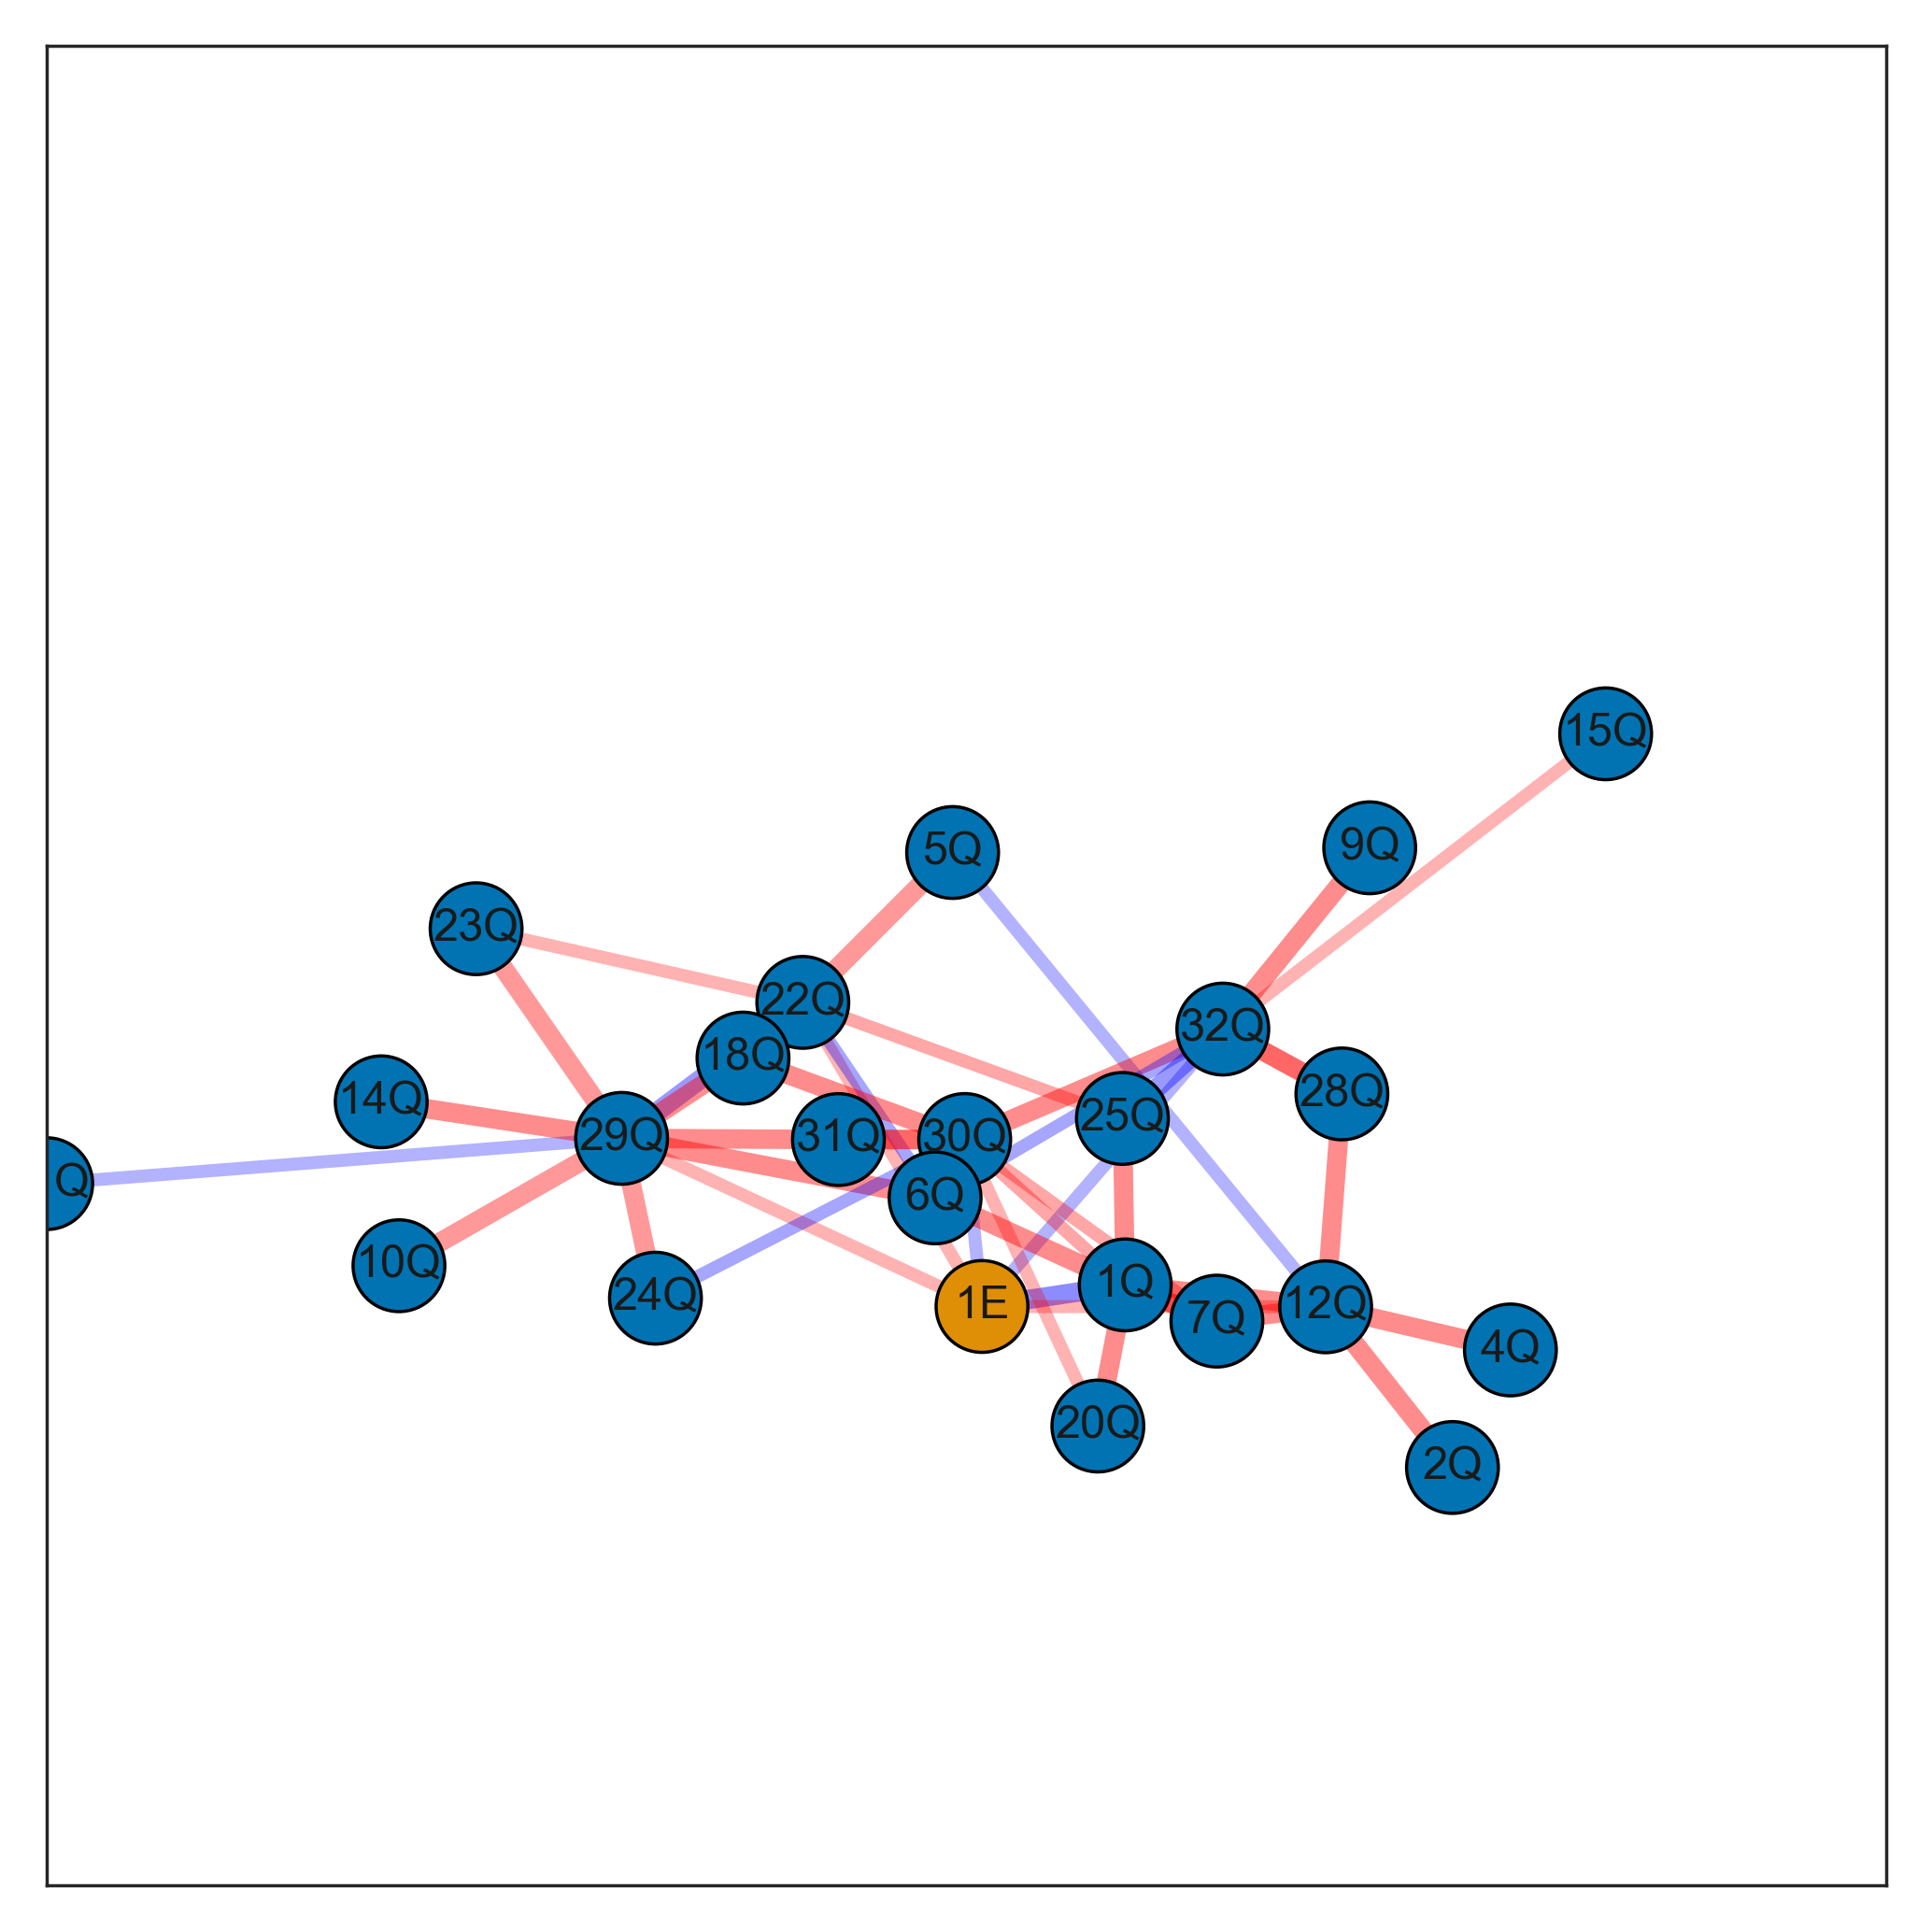

In [56]:
draw_graph_diff(diff_graph, seed=2, pos=None) # draw later with https://github.com/gephi/gephi/wiki

In [57]:
node_list = list(diff_graph_cov.nodes())
pos = manifold_position(results_ern_lat_demo_df, node_list, mapping_ern)

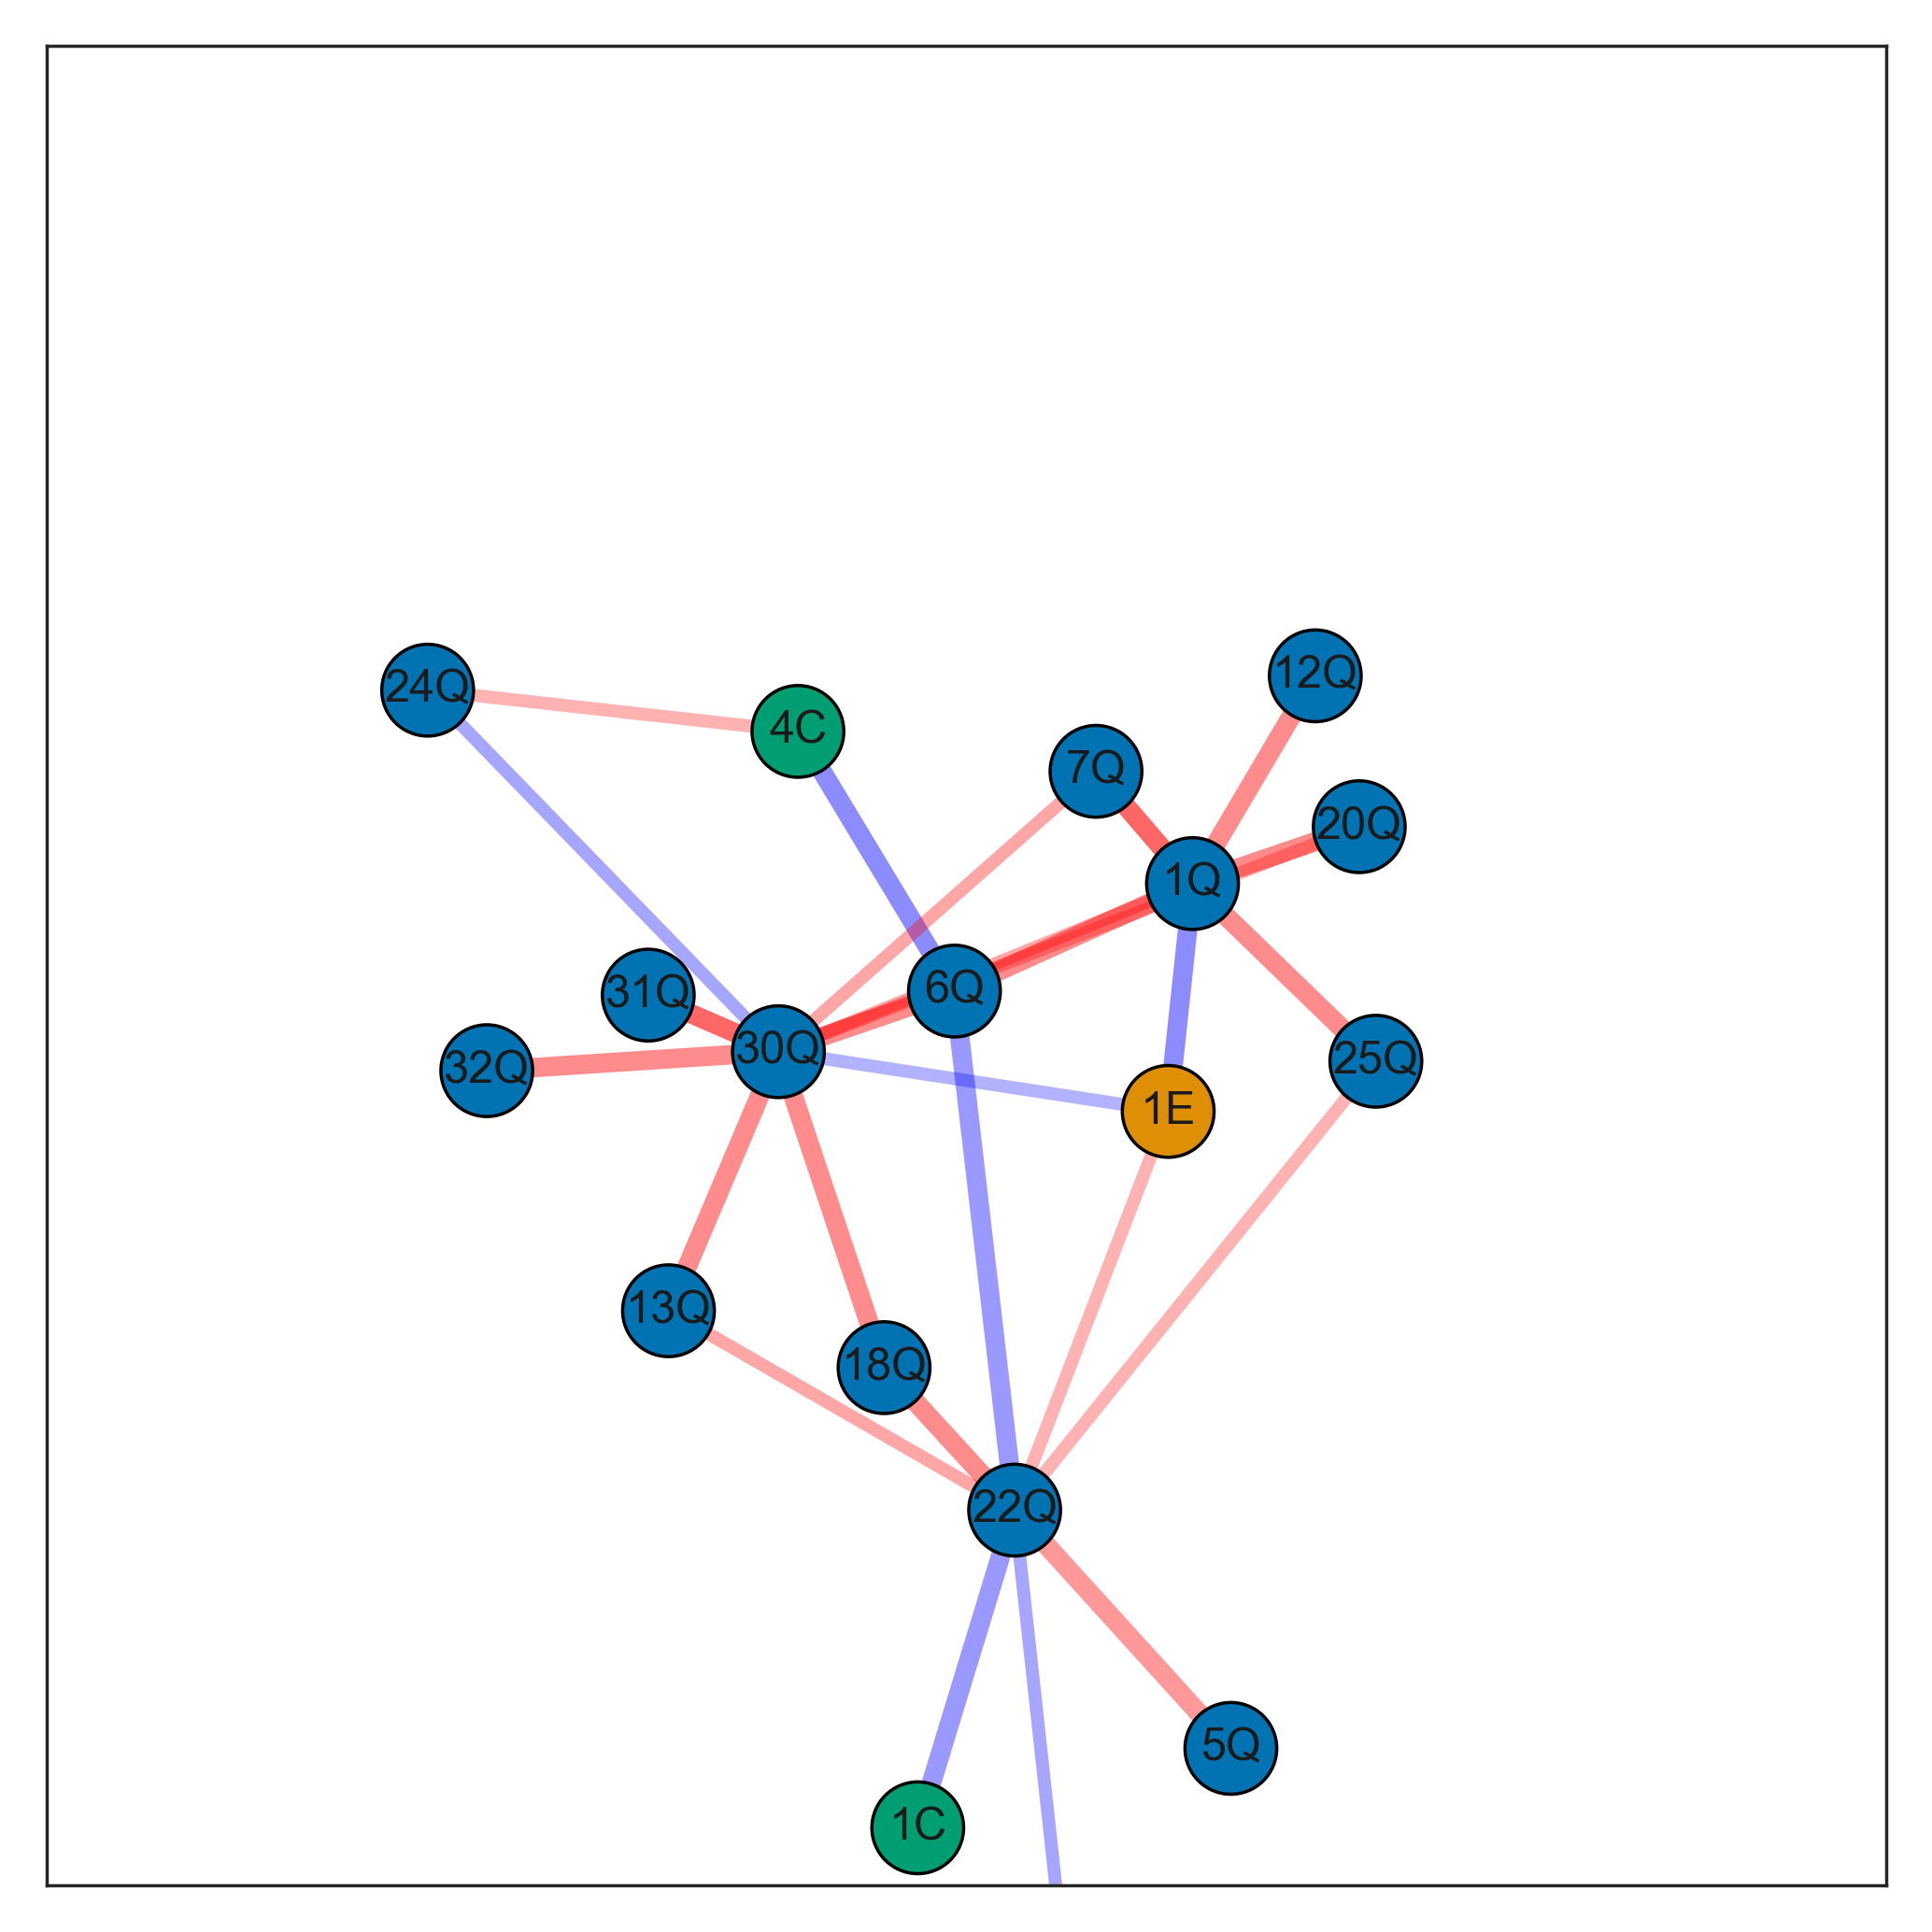

In [65]:
draw_graph_diff(diff_graph_cov, pos=None, seed=5)

---
## Draw legend

In [166]:
legend_labels = {
    "1Q: Rumination": "1Q",
    "2Q: DASS-21 Stress": "2Q",
    "3Q: DASS-21 Depression": "3Q",
    "4Q: STAI-T": "4Q",
    "5Q: STAI-S S1-S2": '5Q',
    "6Q: Behavioral Inhibition": "6Q",
    "7Q: Obsessing": "7Q",
    "8Q: Hoarding": "8Q",
    "9Q: Ordering": "9Q",
    "10Q: Checking": "10Q",
    "11Q: OCI-R": "11Q",
    "12Q: Thought Supression": "12Q",
    "13Q: Prospective IU": "13Q",
    "14Q: Inhibitory IU": "14Q",
    "15Q: Self-esteem": "15Q",
    '16Q: BAS Drive': "16Q",
    '17Q: BAS Fun Seeking': "17Q",
    '18Q: BAS Reward Responsiveness': "18Q",
    '19Q: Nonforgivness': "19Q",
    '20Q: Indecisivness': "20Q",
    '21Q: Punishment Sensitivity': "21Q",
    '22Q: Reward Sensitivity': "22Q",
    '23Q: Inflated harm responsibility': "23Q",
    '24Q: Thought Control': "24Q",
    "25Q: Threat Overestimation": "25Q",
    '26Q: OB Perfectionism': "26Q",
    '27Q: Concern over Mistakes': "27Q",
    '28Q: Personal Standards': "28Q",
    '29Q: Guilt Sensitivity': "29Q",
    '30Q: Avoidance of Ambiguity': "30Q",
    '31Q: Need for Predictability': "31Q",
    '32Q: High standards': "32Q",   
    "1C: Age": "1C",
    "2C: Sex": "2C",
    "3C: Handedness": "3C",
    '4C: ERP latency': "4C",
    '5C: Performance': "5C",
    '1E: ERN': "1E",
    '2E: CRN': "2E",
}

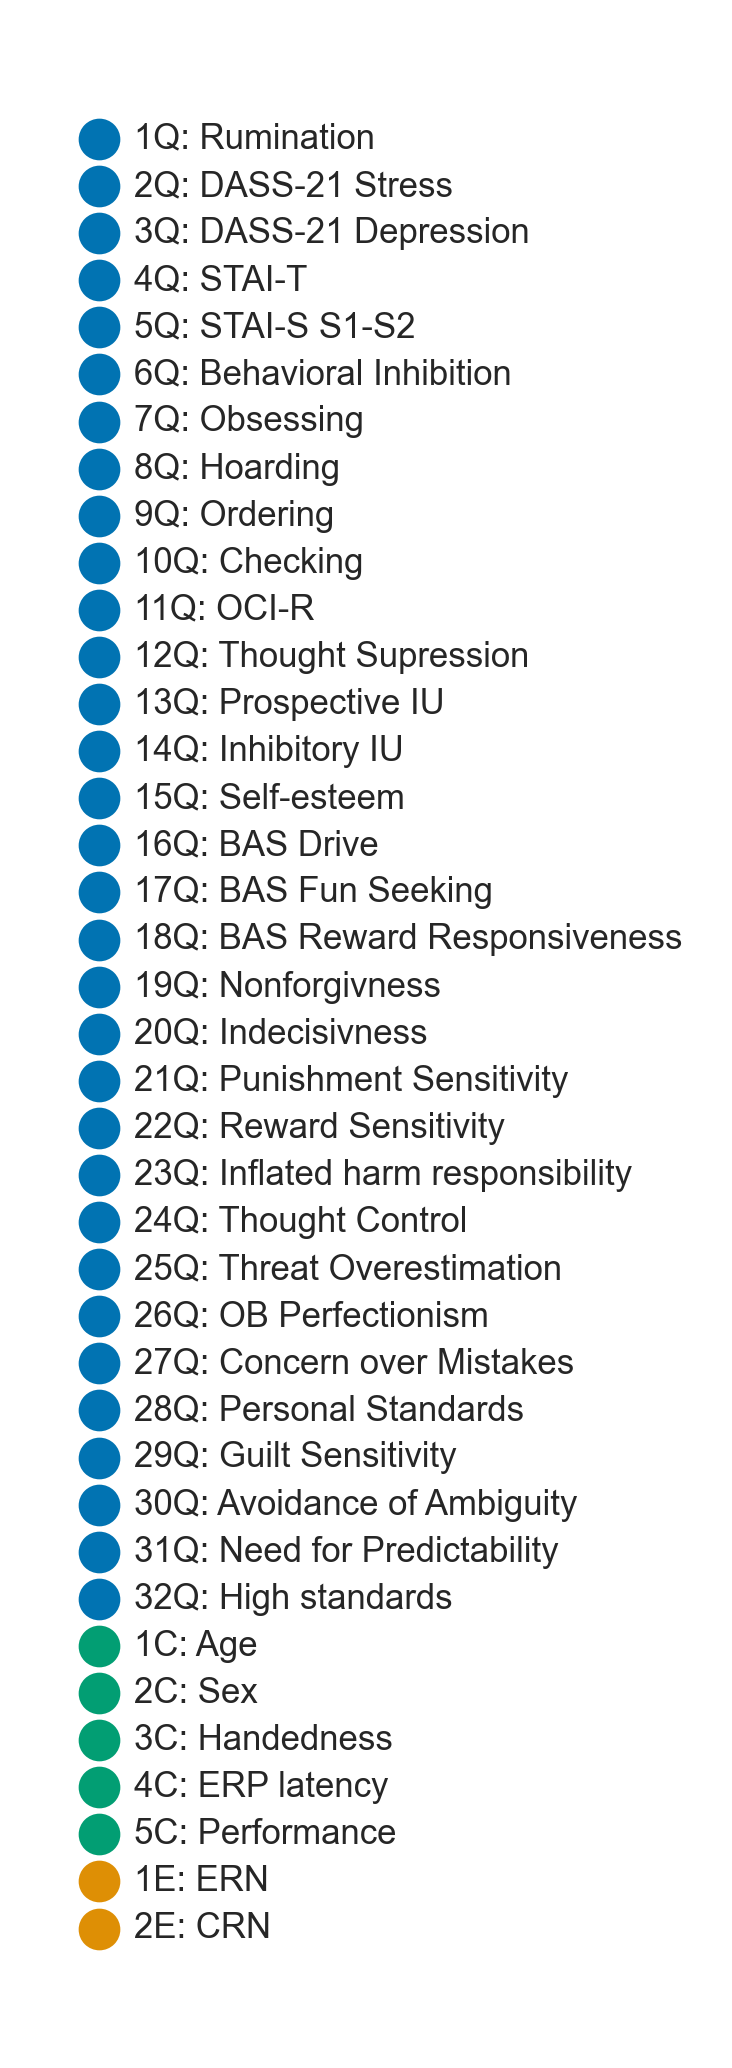

In [167]:
cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
sns.set_style("white")


palette = sns.color_palette("colorblind")

fig = plt.figure(3, figsize=(10*cm, 10*cm))
ax = fig.add_axes([0,0,1,1], aspect=1)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
# ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
    
# # change default range so that new circles will work
# ax.set_xlim((0, 10))
# ax.set_ylim((0, 10))
# some data
x = [0.5]*len(legend_labels)
y = np.linspace(0,1,len(legend_labels))

nodes_color=[palette[0] if item[1].find('Q') != -1 
                else palette[1]if item[1].find('E') != -1 
                else palette[2] for item in legend_labels.items()]


    
# ax.plot(x, y, 'o', color=nodes_color,  markersize=4)

for i, item in enumerate(legend_labels.items()):
    item_index = len(legend_labels) - i - 1
    
    ax.plot(
        x[item_index],
        y[item_index], 
        'o', 
        markersize=5,
        color=nodes_color[i],
    )
    
    plt.annotate(
        item[0],                       # label text
        (x[item_index], y[item_index]),                    # (x, y)
        textcoords="offset points",   
        xytext=(5, -1.35),               # (x, y) offset amount
        ha='left',
        fontsize=5
    )
    
plt.show()